# Analyzing PSP Data Using pySPEDAS
###### https://pyspedas.readthedocs.io/en/latest/psp.html

# SWEAP
- http://sweap.cfa.harvard.edu/sweap_data_user_guide.pdf

## Solar Probe Cup (SPC)

#### Velocity

28-Dec-22 20:32:40: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2021/


Using LEVEL=L3


28-Dec-22 20:32:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210424_v02.cdf
28-Dec-22 20:32:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
28-Dec-22 20:32:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
28-Dec-22 20:32:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
28-Dec-22 20:32:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
28-Dec-22 20:32:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf


['psp_spc_Epoch', 'psp_spc_DQF', 'psp_spc_np_fit', 'psp_spc_np_fit_uncertainty', 'psp_spc_wp_fit', 'psp_spc_wp_fit_uncertainty', 'psp_spc_vp_fit_SC', 'psp_spc_vp_fit_SC_uncertainty', 'psp_spc_vp_fit_RTN', 'psp_spc_vp_fit_RTN_uncertainty', 'psp_spc_np1_fit', 'psp_spc_np1_fit_uncertainty', 'psp_spc_wp1_fit', 'psp_spc_wp1_fit_uncertainty', 'psp_spc_vp1_fit_SC', 'psp_spc_vp1_fit_SC_uncertainty', 'psp_spc_vp1_fit_RTN', 'psp_spc_vp1_fit_RTN_uncertainty', 'psp_spc_np_moment', 'psp_spc_np_moment_deltahigh', 'psp_spc_np_moment_deltalow', 'psp_spc_wp_moment', 'psp_spc_wp_moment_deltahigh', 'psp_spc_wp_moment_deltalow', 'psp_spc_vp_moment_SC', 'psp_spc_vp_moment_SC_deltahigh', 'psp_spc_vp_moment_SC_deltalow', 'psp_spc_vp_moment_RTN', 'psp_spc_vp_moment_RTN_deltahigh', 'psp_spc_vp_moment_RTN_deltalow', 'psp_spc_na_fit', 'psp_spc_na_fit_uncertainty', 'psp_spc_wa_fit', 'psp_spc_wa_fit_uncertainty', 'psp_spc_va_fit_SC', 'psp_spc_va_fit_SC_uncertainty', 'psp_spc_va_fit_RTN', 'psp_spc_va_fit_RTN_uncert

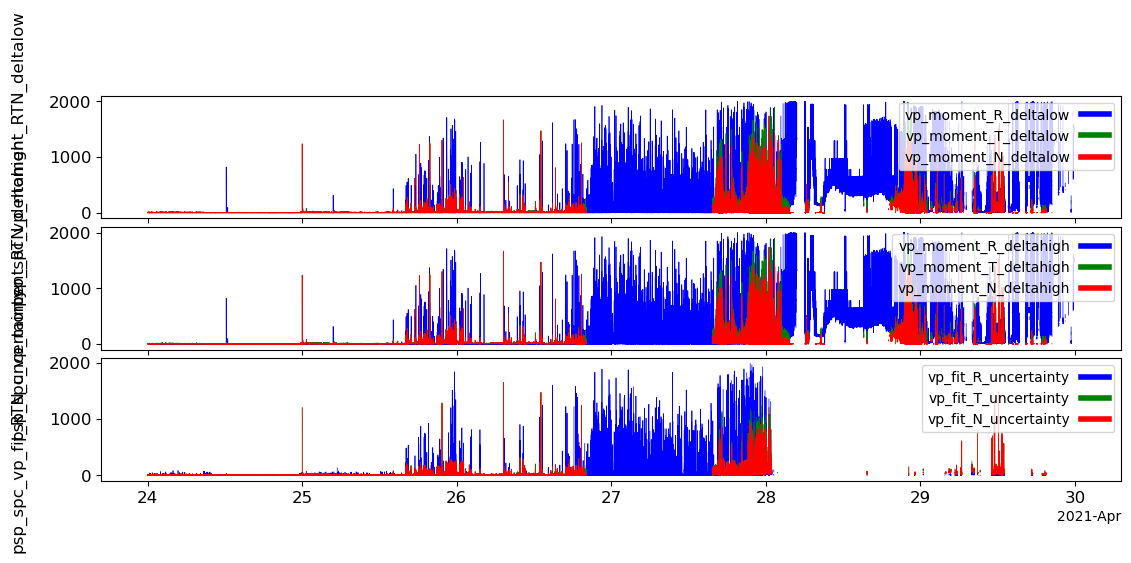

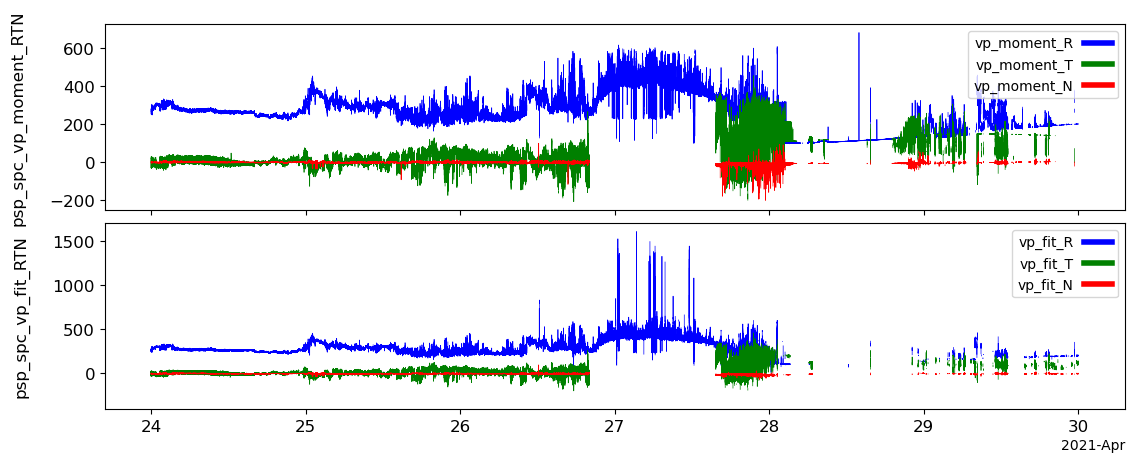

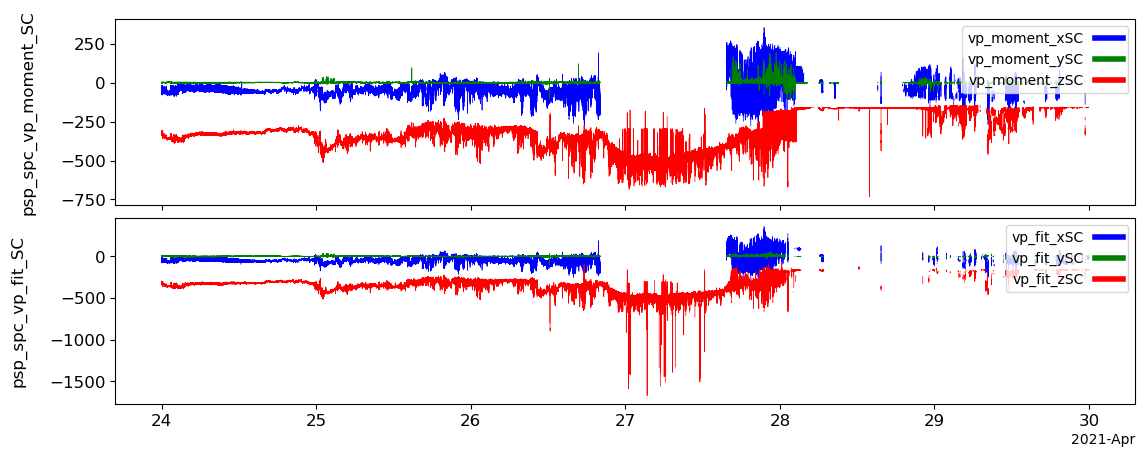

In [77]:
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
spc_vars_tplot = pyspedas.psp.spc(trange=['2021-04-24', '2021-04-30'], datatype='l3i', level='l3', get_support_data=True, notplot=False, no_update=False)
print(spc_vars_tplot)
tplot(['psp_spc_vp_moment_RTN_deltalow', 'psp_spc_vp_moment_RTN_deltahigh', 'psp_spc_vp_fit_RTN_uncertainty'])
tplot(['psp_spc_vp_moment_RTN','psp_spc_vp_fit_RTN'])
tplot(['psp_spc_vp_moment_SC','psp_spc_vp_fit_SC'])

The first thing I noticed was how there are huge spikes in the vp_fit data compared to vp_moment, which seems like it might be anomalous (my analysis of the wp data below suggests that this could indeed be the case, and so I ended deciding to use moment, not fit, data). The difference between RTN and SC is just the reference frame for the coordinate system, and they give pretty much the same velocities (albeit in slightly different reference frames), so I don't think it matters that much which one I use. In the end, I went with the vp_moment_RTN to process and incorporate into the website.

29-Dec-22 21:42:52: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2021/


Using LEVEL=L3


29-Dec-22 21:42:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210424_v02.cdf
29-Dec-22 21:42:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
29-Dec-22 21:42:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
29-Dec-22 21:42:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
29-Dec-22 21:42:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
29-Dec-22 21:42:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
29-Dec-22 21:42:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
29-Dec-22 21:42:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
29-Dec-22 21:42:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
29-Dec-22 21:42:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

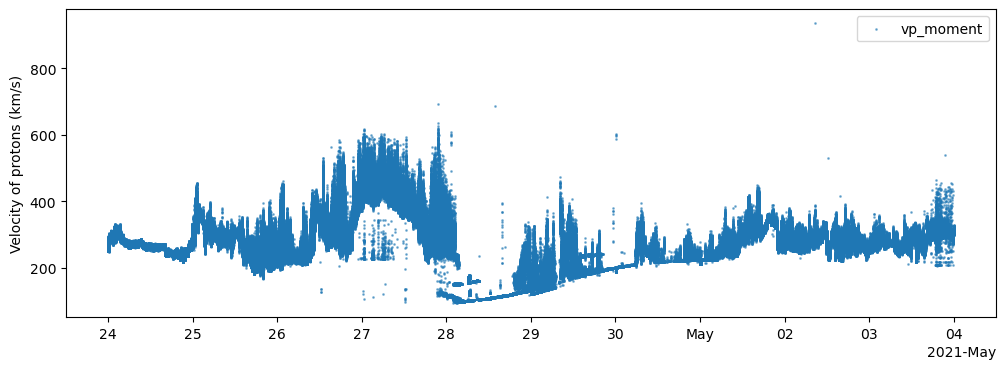

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot

spc_vars = pyspedas.psp.spc(trange=['2021-04-24', '2021-05-04'], datatype='l3i', level='l3', get_support_data=True, notplot=True, no_update=False)
t1 = spc_vars['psp_spc_vp_moment_RTN']['x']
v1 = spc_vars['psp_spc_vp_moment_RTN']['y']
# t2 = spc_vars['psp_spc_vp_fit_RTN']['x']
# v2 = spc_vars['psp_spc_vp_fit_RTN']['y']
velocities1 = []
for row in v1:
    total = 0
    for dir in row:
        if np.isnan(dir):
            continue
        total += dir**2
    total = math.sqrt(total)
    if total==0:
        total = row[0]
    velocities1.append(total)
fig1, ax1 = plt.subplots(figsize=(12, 4))
ax1.scatter(t1, np.array(velocities1), label="vp_moment", s=1, alpha=0.5)
ax1.set_ylabel("Velocity of protons (km/s)")
ax1.legend()

In [120]:
spcvelocitydata = pd.DataFrame(np.array(velocities1))
print(f'Percent NaN: {spcvelocitydata.isna().sum().sum() / spcvelocitydata.size * 100:.3f}%')
spcvelocitydata.head()

Percent NaN: 14.213%


,0
0,NaN
1,268.643363
2,267.162021
3,272.166154
4,269.837284


#### Density

['psp_spc_Epoch', 'psp_spc_DQF', 'psp_spc_np_fit', 'psp_spc_np_fit_uncertainty', 'psp_spc_wp_fit', 'psp_spc_wp_fit_uncertainty', 'psp_spc_vp_fit_SC', 'psp_spc_vp_fit_SC_uncertainty', 'psp_spc_vp_fit_RTN', 'psp_spc_vp_fit_RTN_uncertainty', 'psp_spc_np1_fit', 'psp_spc_np1_fit_uncertainty', 'psp_spc_wp1_fit', 'psp_spc_wp1_fit_uncertainty', 'psp_spc_vp1_fit_SC', 'psp_spc_vp1_fit_SC_uncertainty', 'psp_spc_vp1_fit_RTN', 'psp_spc_vp1_fit_RTN_uncertainty', 'psp_spc_np_moment', 'psp_spc_np_moment_deltahigh', 'psp_spc_np_moment_deltalow', 'psp_spc_wp_moment', 'psp_spc_wp_moment_deltahigh', 'psp_spc_wp_moment_deltalow', 'psp_spc_vp_moment_SC', 'psp_spc_vp_moment_SC_deltahigh', 'psp_spc_vp_moment_SC_deltalow', 'psp_spc_vp_moment_RTN', 'psp_spc_vp_moment_RTN_deltahigh', 'psp_spc_vp_moment_RTN_deltalow', 'psp_spc_na_fit', 'psp_spc_na_fit_uncertainty', 'psp_spc_wa_fit', 'psp_spc_wa_fit_uncertainty', 'psp_spc_va_fit_SC', 'psp_spc_va_fit_SC_uncertainty', 'psp_spc_va_fit_RTN', 'psp_spc_va_fit_RTN_uncert

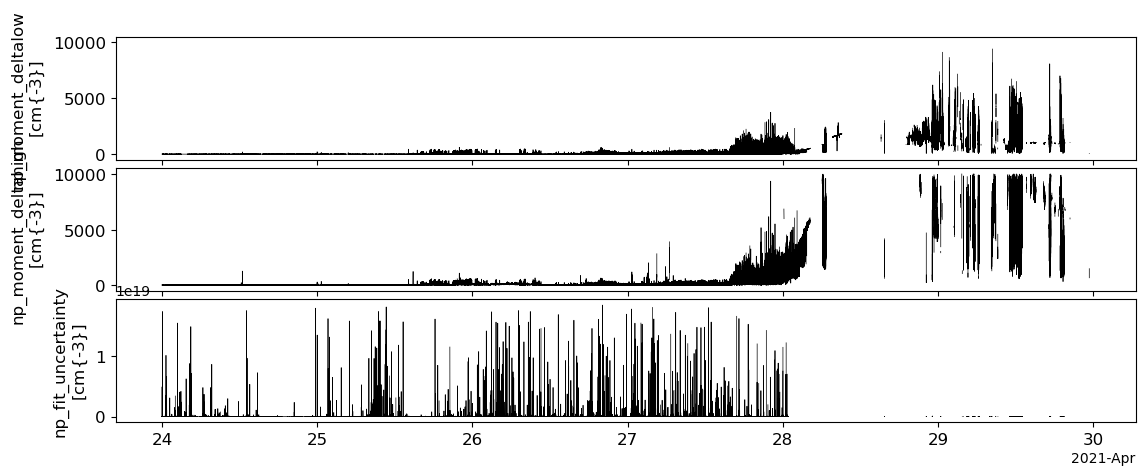

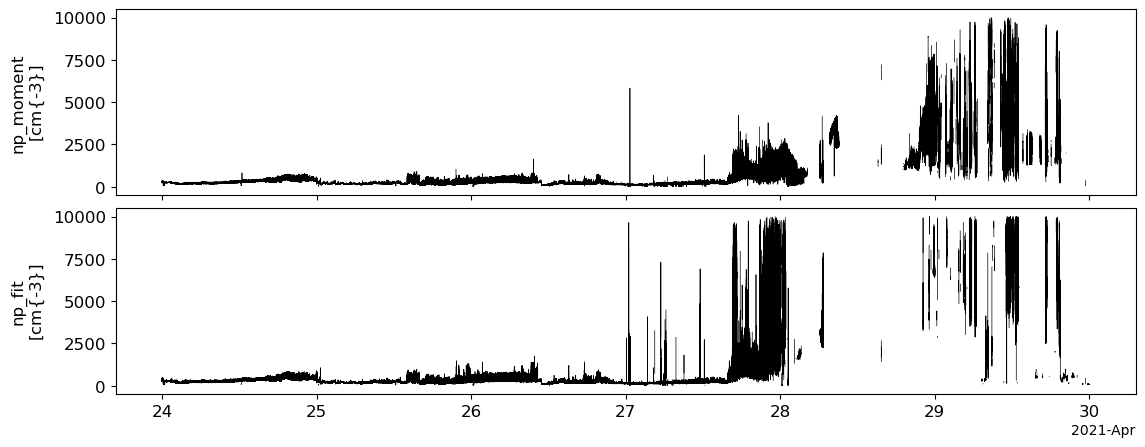

In [7]:
print(spc_vars)
tplot(['psp_spc_np_moment_deltalow', 'psp_spc_np_moment_deltahigh', 'psp_spc_np_fit_uncertainty'])
tplot(['psp_spc_np_moment','psp_spc_np_fit'])

There doesn't seem to be any huge discrepencies between the np_moment and np_fit data, although the fit data is significantly higher just before April 28. So I'm just going to use np_moment to make it consistent across these data sets.

In [99]:
densitydata = pd.DataFrame(spc_vars['psp_spc_np_moment']['y'])
print(f'Percent NaN: {densitydata.isna().sum().sum() / densitydata.size * 100:.3f}%')
densitydata.head()

Percent nan: 30.564%


,0
0,NaN
1,293.406555
2,303.205963
3,282.891449
4,298.371857


#### Temperature

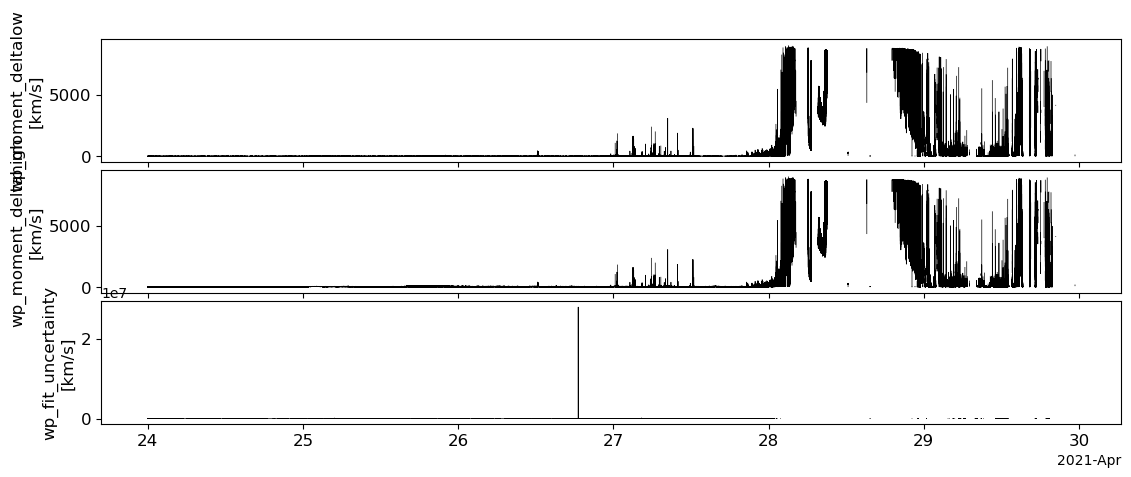

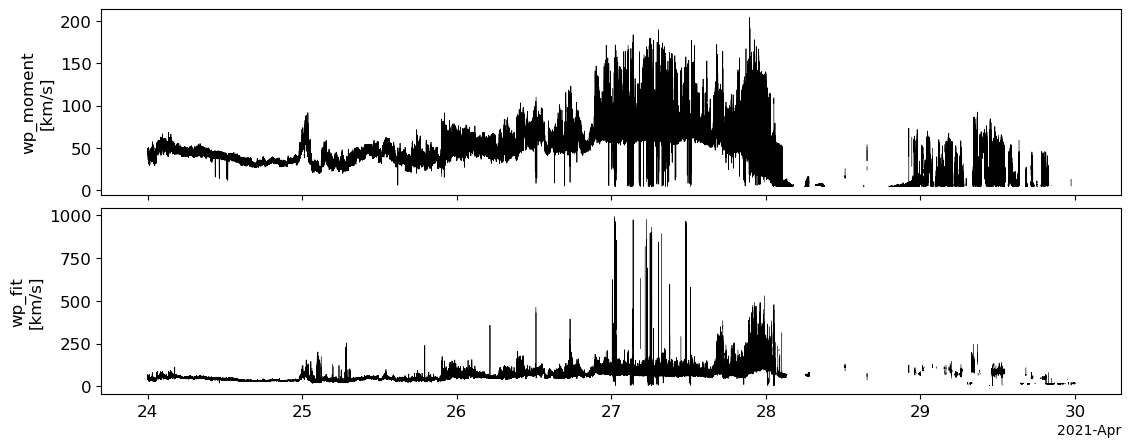

In [8]:
tplot(['psp_spc_wp_moment_deltalow', 'psp_spc_wp_moment_deltahigh', 'psp_spc_wp_fit_uncertainty'])
tplot(['psp_spc_wp_moment','psp_spc_wp_fit'])

In a similar fashion to the velocity data, this thermal speed data also had huge spikes in the wp_fit graph (up to 1000 km/s), whereas the wp_moment graph stayed relatively consistent within 20-200 km/s. So I used T = (mv^2)/2k to calculate example temperatures: 150 km/s turned out to be around 1.36 million Kelvin, which is reasonably accurate to the actual temperature of the corona (and the PSP is indeed inside the corona at this time), but 1000 km/s was a whopping 60.57 million Kelvin, which I think is likely some sort of error as that is way hotter than even the sun's core (15 million Kelvin). As a result, I decided that it'd be better to use the moment data across the board (instead of fit), also taking into consideration this important note from the SWEAP user guide.

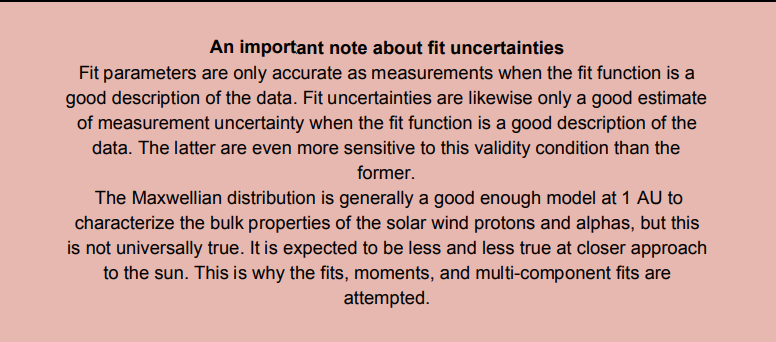

Now, of course, since I am only using this data in order to visualize it and help people understand it better (not for any scientific purpose), accuracy of measurement is not necessarily a requirement, but I have still tried to pick the data set (between moment & fit) that best represents what SWEAP is trying to measure.

In [100]:
thermaldata = pd.DataFrame(spc_vars['psp_spc_wp_moment']['y'])
print(f'Percent NaN: {thermaldata.isna().sum().sum() / thermaldata.size * 100:.3f}%')
thermaldata.head()

Percent NaN: 22.977%


,0
0,NaN
1,43.223606
2,46.065052
3,42.926537
4,45.981846


### SPAN-e (electrons)

29-Dec-22 21:44:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2021/
29-Dec-22 21:44:20: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210424_v03.cdf
29-Dec-22 21:44:20: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210425_v03.cdf
29-Dec-22 21:44:20: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210426_v03.cdf
29-Dec-22 21:44:20: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210427_v03.cdf
29-Dec-22 21:44:20: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210428_v03.cdf
29-Dec-22 21:44:20: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210429_v03.cdf
29-Dec-22 21:44:20: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210430_v03.cdf
29-Dec-22 21:44:20: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/

['psp_spe_QUALITY_FLAG', 'psp_spe_EFLUX']


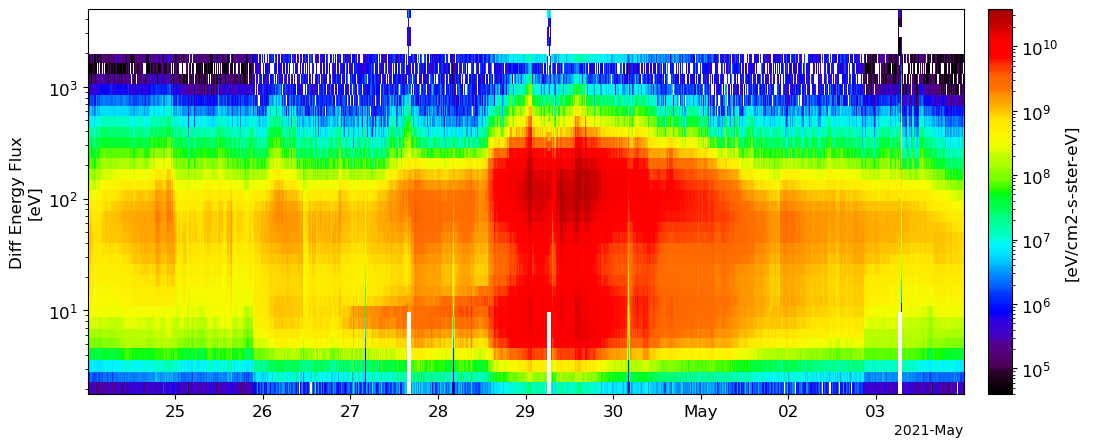

In [4]:
import pandas as pd
spe_vars_tplot = pyspedas.psp.spe(trange=['2021-04-24', '2021-05-04'], datatype='spa_sf1_32e', level='l2', notplot=False, time_clip=False)
print(spe_vars_tplot)
tplot('psp_spe_EFLUX')

In [6]:
spe_vars = pyspedas.psp.spe(trange=['2021-04-24', '2021-05-04'], datatype='spa_sf1_32e', level='l2', notplot=True, time_clip=False)

29-Dec-22 21:44:53: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2021/
29-Dec-22 21:44:53: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210424_v03.cdf
29-Dec-22 21:44:53: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210425_v03.cdf
29-Dec-22 21:44:53: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210426_v03.cdf
29-Dec-22 21:44:53: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210427_v03.cdf
29-Dec-22 21:44:53: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210428_v03.cdf
29-Dec-22 21:44:54: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210429_v03.cdf
29-Dec-22 21:44:54: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210430_v03.cdf
29-Dec-22 21:44:54: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/

In [12]:
efluxdata = pd.DataFrame(spe_vars['psp_spe_EFLUX']['y'])
print(f'Percent NaN: {efluxdata.isna().sum().sum() / efluxdata.size * 100:.3f}%')
efluxdata.shape

Percent NaN: 0.000%


(494383, 32)

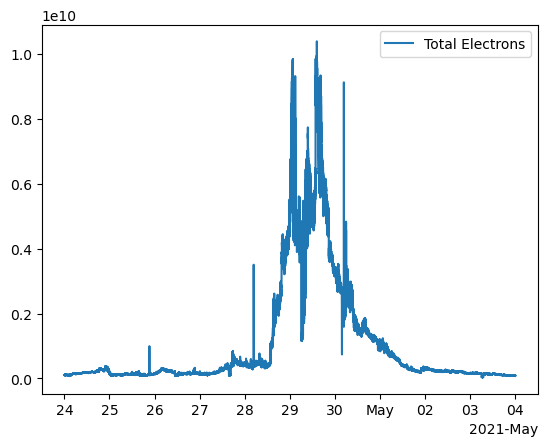

In [37]:
# Estimations of the average energies (eV) for the 32 different electron energy bins obtained from the graph above
energy_bins = [2,2.6,3.3,4.2,5.1,6.1,7.9,9.9,12.5,15,19,24,29,36,45,56,70,88,112,133,175,212,257,333,400,490,600,780,950,1200,1500,1800]

totalelectrons = []
for row in spe_vars['psp_spe_EFLUX']['y']:
    total = 0
    for i in range(32):
        total += row[i] / energy_bins[i]
    totalelectrons.append(total)
plt.plot(spe_vars['psp_spe_EFLUX']['x'], np.array(totalelectrons), label='Total Electrons')
plt.legend()

### SPAN-i (ions)

08-Jan-23 21:15:03: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf0a_mom_inst/2021/
08-Jan-23 21:15:03: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210424_v03.cdf
08-Jan-23 21:15:04: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210425_v03.cdf
08-Jan-23 21:15:04: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210426_v03.cdf
08-Jan-23 21:15:04: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210427_v03.cdf
08-Jan-23 21:15:04: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210428_v03.cdf
08-Jan-23 21:15:04: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210429_v03.cdf


['psp_spi_QUALITY_FLAG', 'psp_spi_DENS', 'psp_spi_VEL', 'psp_spi_T_TENSOR', 'psp_spi_TEMP', 'psp_spi_EFLUX_VS_ENERGY', 'psp_spi_EFLUX_VS_THETA', 'psp_spi_EFLUX_VS_PHI', 'psp_spi_MAGF_SC', 'psp_spi_MAGF_INST']


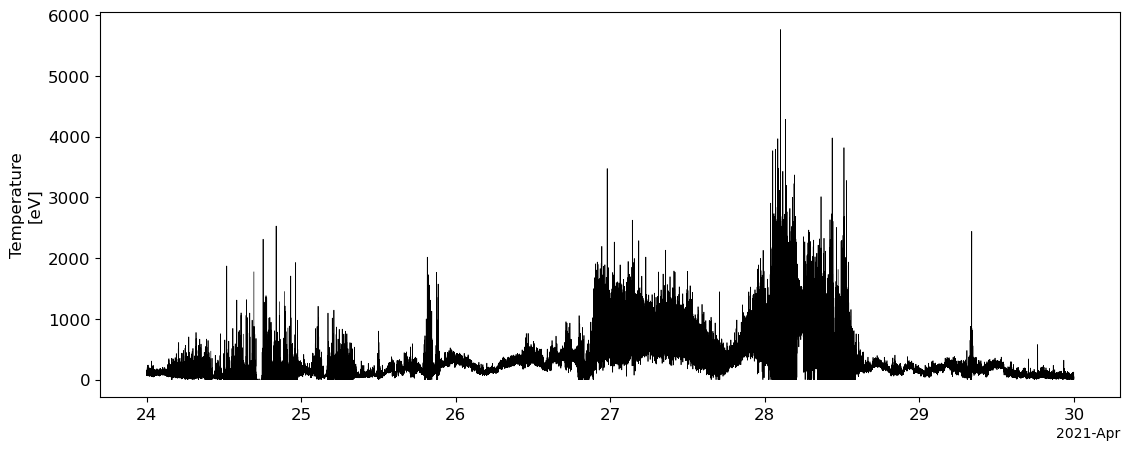

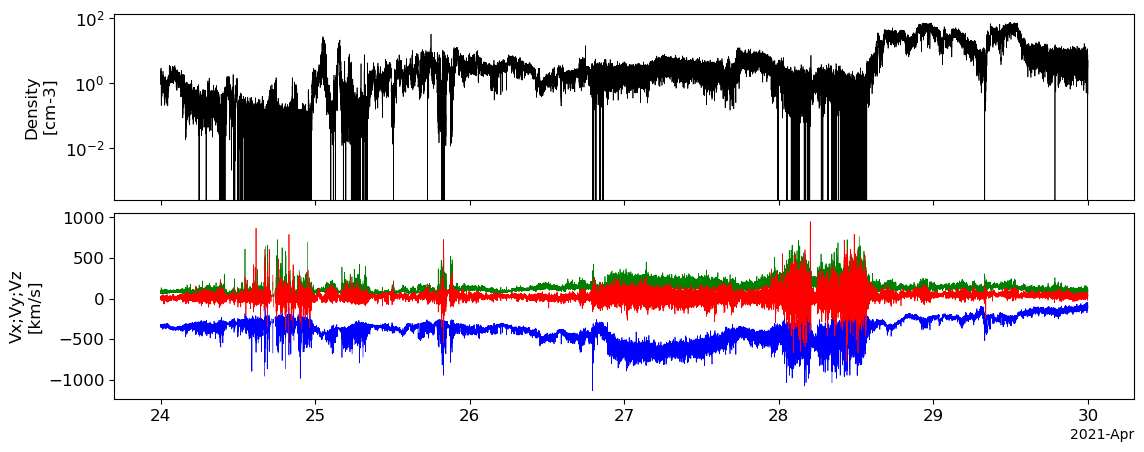

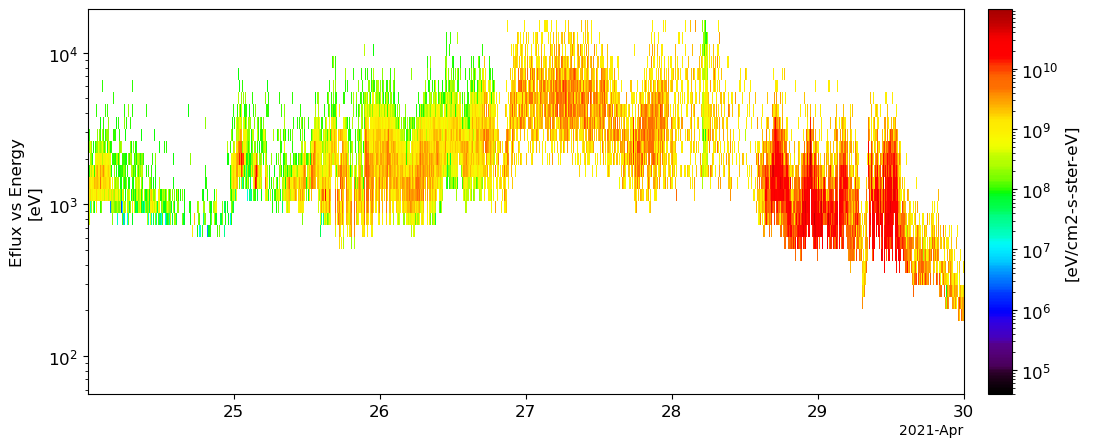

In [19]:
spi_vars_tplot = pyspedas.psp.spi(trange=['2021-04-24', '2021-04-30'], datatype='spi_sf0a_mom_inst', level='l3', time_clip=False)
print(spi_vars_tplot)
tplot(['psp_spi_TEMP'])
tplot(['psp_spi_DENS', 'psp_spi_VEL'])
tplot(['psp_spi_EFLUX_VS_ENERGY'])
#tplot(['psp_spi_MAGF_SC', 'psp_spi_MAGF_INST'])

In [46]:
spi_vars = pyspedas.psp.spi(trange=['2021-04-24', '2021-04-30'], datatype='spi_sf0a_mom_inst', level='l3', notplot=True, time_clip=False)

29-Dec-22 22:27:47: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf0a_mom_inst/2021/
29-Dec-22 22:27:47: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210424_v03.cdf
29-Dec-22 22:27:47: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210425_v03.cdf
29-Dec-22 22:27:47: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210426_v03.cdf
29-Dec-22 22:27:47: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210427_v03.cdf
29-Dec-22 22:27:48: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210428_v03.cdf
29-Dec-22 22:27:48: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210429_v03.cdf


In [47]:
spifluxdata = pd.DataFrame(spi_vars['psp_spi_EFLUX_VS_ENERGY']['y'])
spifluxdata.shape

(148283, 32)

In [48]:
spitempdata = pd.DataFrame(spi_vars['psp_spi_TEMP']['y'])
print(f'Percent NaN: {spitempdata.isna().sum().sum() / spitempdata.size * 100:.3f}%')
spitempdata.head()

Percent NaN: 2.035%


,0
0,67.940468
1,82.127098
2,127.671227
3,73.690308
4,107.201820


### Spacecraft Position

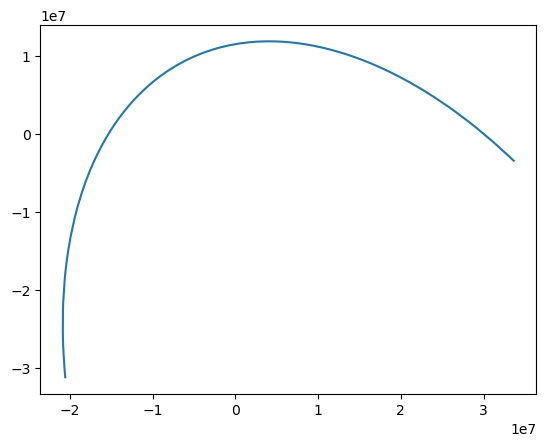

In [119]:
pos = spc_vars['psp_spc_sc_pos_HCI']['y']
spc_vars['psp_spc_sc_pos_HCI']['y'][:,0]
plt.plot(-spc_vars['psp_spc_sc_pos_HCI']['y'][:,0], spc_vars['psp_spc_sc_pos_HCI']['y'][:,1])
dist = []
for row in pos:
    dist.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2) / 149597870.7)

In [114]:
spc_vars['psp_spc_sc_pos_HCI']['y'][:,0]

array([ 20561126.,  20561128.,  20561130., ..., -33641132., -33641180.,
       -33641224.], dtype=float32)

### Spacecraft Velocity

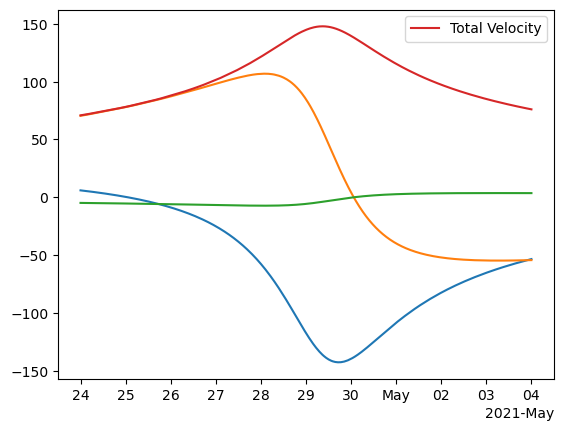

In [113]:
plt.plot(spc_vars['psp_spc_sc_vel_HCI']['x'], spc_vars['psp_spc_sc_vel_HCI']['y'])
velocityvectors = spc_vars['psp_spc_sc_vel_HCI']['y']
pspvelocity = []
for row in velocityvectors:
    pspvelocity.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2))
plt.plot(spc_vars['psp_spc_sc_vel_HCI']['x'], np.array(pspvelocity), label="Total Velocity")
plt.legend()

## SPC Data Processing

In [85]:
# Checking the percent NaN values
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

orbit_dates = [
['2018-11-01', '2018-11-11'],
['2019-03-30', '2019-04-10'],
['2019-08-27', '2019-09-07'],
['2020-01-23', '2020-02-04'],
['2020-06-01', '2020-06-13'],
['2020-09-21', '2020-10-02'],
['2021-01-12', '2021-01-23'],
['2021-04-24', '2021-05-04'],
['2021-08-04', '2021-08-15'],
['2021-11-16', '2021-11-26'],
['2022-02-20', '2022-03-02'],
['2022-05-27', '2022-06-07'],
]

NUMORBITS = 12
m = 1.67262192 * 10**(-27) # Mass of a proton (kg)
k = 1.380649 * 10**(-23) # Boltzmann constant (J/K)
for orbit in range(1, NUMORBITS+1):
    print(f"- - ORBIT {orbit} - -")
    spc_vars = pyspedas.psp.spc(trange=orbit_dates[orbit-1], datatype='l3i', level='l3', get_support_data=True, notplot=True, no_update=False)
    # Velocity
    t1 = spc_vars['psp_spc_vp_moment_RTN']['x']
    v1 = spc_vars['psp_spc_vp_moment_RTN']['y']
    velocities1 = []
    for row in v1:
        total = 0
        for dir in row:
            if np.isnan(dir):
                continue
            total += dir**2
        total = math.sqrt(total)
        if total==0:
            total = row[0]
        velocities1.append(total)
    velodata = pd.DataFrame(np.array(velocities1))
    print(f'Velocity % NaN: {velodata.isna().sum().sum() / velodata.size * 100:.3f}%')
    # Density
    densitydata = pd.DataFrame(spc_vars['psp_spc_np_moment']['y'])
    print(f'Density % NaN: {densitydata.isna().sum().sum() / densitydata.size * 100:.3f}%')
    # Temperature
    thermaldata = pd.DataFrame(spc_vars['psp_spc_wp_moment']['y'])
    print(f'Temperature % NaN: {thermaldata.isna().sum().sum() / thermaldata.size * 100:.3f}%')
    # Spacecraft Velocity
    velocityvectors = spc_vars['psp_spc_sc_vel_HCI']['y']
    pspvelocity = []
    for row in velocityvectors:
        pspvelocity.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2))
    pspvelodata = pd.DataFrame(np.array(pspvelocity))
    print(f'PSP Velocity % NaN: {pspvelodata.isna().sum().sum() / pspvelodata.size * 100:.3f}%')

01-Jan-23 09:40:27: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/


- - ORBIT 1 - -
Using LEVEL=L3


01-Jan-23 09:40:27: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181101_v01.cdf
01-Jan-23 09:40:27: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
01-Jan-23 09:40:27: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
01-Jan-23 09:40:28: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
01-Jan-23 09:40:28: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
01-Jan-23 09:40:28: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
01-Jan-23 09:40:28: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
01-Jan-23 09:40:28: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
01-Jan-23 09:40:29: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
01-Jan-23 09:40:29: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_2018111

Velocity % NaN: 0.457%
Density % NaN: 1.526%
Temperature % NaN: 0.544%


01-Jan-23 09:41:02: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2019/
01-Jan-23 09:41:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190330_v01.cdf


PSP Velocity % NaN: 0.000%
- - ORBIT 2 - -
Using LEVEL=L3


01-Jan-23 09:41:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
01-Jan-23 09:41:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
01-Jan-23 09:41:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
01-Jan-23 09:41:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
01-Jan-23 09:41:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
01-Jan-23 09:41:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
01-Jan-23 09:41:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
01-Jan-23 09:41:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
01-Jan-23 09:41:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190408_v01.cdf
01-Jan-23 09:41:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Velocity % NaN: 21.847%
Density % NaN: 24.665%
Temperature % NaN: 23.557%


01-Jan-23 09:42:41: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2019/


PSP Velocity % NaN: 0.000%
- - ORBIT 3 - -
Using LEVEL=L3


01-Jan-23 09:42:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190827_v01.cdf
01-Jan-23 09:42:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
01-Jan-23 09:42:42: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
01-Jan-23 09:42:42: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf


Velocity % NaN: 0.028%
Density % NaN: 0.252%
Temperature % NaN: 0.040%


01-Jan-23 09:42:56: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


PSP Velocity % NaN: 0.000%
- - ORBIT 4 - -
Using LEVEL=L3


01-Jan-23 09:42:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
01-Jan-23 09:42:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
01-Jan-23 09:42:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
01-Jan-23 09:42:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
01-Jan-23 09:42:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
01-Jan-23 09:42:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
01-Jan-23 09:42:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
01-Jan-23 09:42:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
01-Jan-23 09:42:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
01-Jan-23 09:42:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Velocity % NaN: 10.125%
Density % NaN: 11.523%
Temperature % NaN: 10.923%


01-Jan-23 09:43:46: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


PSP Velocity % NaN: 0.000%
- - ORBIT 5 - -
Using LEVEL=L3


01-Jan-23 09:43:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
01-Jan-23 09:43:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
01-Jan-23 09:43:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
01-Jan-23 09:43:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
01-Jan-23 09:43:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
01-Jan-23 09:43:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
01-Jan-23 09:43:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
01-Jan-23 09:43:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
01-Jan-23 09:43:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
01-Jan-23 09:43:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Velocity % NaN: 5.965%
Density % NaN: 8.090%
Temperature % NaN: 7.419%


01-Jan-23 09:44:30: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


PSP Velocity % NaN: 0.000%
- - ORBIT 6 - -
Using LEVEL=L3


01-Jan-23 09:44:30: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200921_v02.cdf
01-Jan-23 09:44:30: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
01-Jan-23 09:44:30: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
01-Jan-23 09:44:30: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
01-Jan-23 09:44:31: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
01-Jan-23 09:44:31: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
01-Jan-23 09:44:31: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
01-Jan-23 09:44:31: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
01-Jan-23 09:44:31: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
01-Jan-23 09:44:31: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020093

Velocity % NaN: 19.128%
Density % NaN: 29.042%
Temperature % NaN: 28.523%


01-Jan-23 09:45:06: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2021/


PSP Velocity % NaN: 0.000%
- - ORBIT 7 - -
Using LEVEL=L3


01-Jan-23 09:45:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
01-Jan-23 09:45:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
01-Jan-23 09:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
01-Jan-23 09:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
01-Jan-23 09:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
01-Jan-23 09:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
01-Jan-23 09:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
01-Jan-23 09:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
01-Jan-23 09:45:08: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
01-Jan-23 09:45:08: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Velocity % NaN: 9.097%
Density % NaN: 26.010%
Temperature % NaN: 21.061%


01-Jan-23 09:45:43: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2021/


PSP Velocity % NaN: 0.000%
- - ORBIT 8 - -
Using LEVEL=L3


01-Jan-23 09:45:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210424_v02.cdf
01-Jan-23 09:45:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
01-Jan-23 09:45:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
01-Jan-23 09:45:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
01-Jan-23 09:45:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
01-Jan-23 09:45:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
01-Jan-23 09:45:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
01-Jan-23 09:45:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
01-Jan-23 09:45:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
01-Jan-23 09:45:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Velocity % NaN: 14.213%
Density % NaN: 30.564%
Temperature % NaN: 22.977%


01-Jan-23 09:46:14: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2021/


PSP Velocity % NaN: 0.000%
- - ORBIT 9 - -
Using LEVEL=L3


01-Jan-23 09:46:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210804_v02.cdf
01-Jan-23 09:46:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
01-Jan-23 09:46:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
01-Jan-23 09:46:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
01-Jan-23 09:46:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
01-Jan-23 09:46:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
01-Jan-23 09:46:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
01-Jan-23 09:46:16: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
01-Jan-23 09:46:16: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
01-Jan-23 09:46:16: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Velocity % NaN: 6.752%
Density % NaN: 23.733%
Temperature % NaN: 8.180%


01-Jan-23 09:46:44: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2021/


PSP Velocity % NaN: 0.000%
- - ORBIT 10 - -
Using LEVEL=L3


01-Jan-23 09:46:45: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211116_v02.cdf
01-Jan-23 09:46:45: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
01-Jan-23 09:46:45: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
01-Jan-23 09:46:45: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
01-Jan-23 09:46:45: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf


Velocity % NaN: 10.447%
Density % NaN: 10.470%
Temperature % NaN: 10.468%


01-Jan-23 09:46:53: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/


PSP Velocity % NaN: 0.000%
- - ORBIT 11 - -
Using LEVEL=L3


01-Jan-23 09:46:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf
01-Jan-23 09:46:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
01-Jan-23 09:46:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
01-Jan-23 09:46:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
01-Jan-23 09:46:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
01-Jan-23 09:46:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
01-Jan-23 09:46:55: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
01-Jan-23 09:46:55: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
01-Jan-23 09:46:55: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
01-Jan-23 09:46:55: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Velocity % NaN: 8.119%
Density % NaN: 15.264%
Temperature % NaN: 10.511%


01-Jan-23 09:47:17: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/


PSP Velocity % NaN: 0.000%
- - ORBIT 12 - -
Using LEVEL=L3


01-Jan-23 09:47:17: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220527_v02.cdf
01-Jan-23 09:47:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
01-Jan-23 09:47:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
01-Jan-23 09:47:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
01-Jan-23 09:47:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
01-Jan-23 09:47:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
01-Jan-23 09:47:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
01-Jan-23 09:47:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
01-Jan-23 09:47:19: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf


Velocity % NaN: 4.919%
Density % NaN: 9.605%
Temperature % NaN: 6.107%
PSP Velocity % NaN: 0.000%


In [113]:
# Processing data and exporting text files
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

orbit_dates = [
['2018-11-01', '2018-11-11'],
['2019-03-30', '2019-04-10'],
['2019-08-27', '2019-09-07'],
['2020-01-23', '2020-02-04'],
['2020-06-01', '2020-06-13'],
['2020-09-21', '2020-10-02'],
['2021-01-12', '2021-01-23'],
['2021-04-24', '2021-05-04'],
['2021-08-04', '2021-08-15'],
['2021-11-16', '2021-11-26'],
['2022-02-20', '2022-03-02'],
['2022-05-27', '2022-06-07'],
]

NUMORBITS = 12
m = 1.67262192 * 10**(-27) # Mass of a proton (kg)
k = 1.380649 * 10**(-23) # Boltzmann constant (J/K)
for orbit in range(1, NUMORBITS+1):
    spc_vars = pyspedas.psp.spc(trange=orbit_dates[orbit-1], datatype='l3i', level='l3', get_support_data=True, notplot=True, no_update=False)
    # Velocity
    t1 = spc_vars['psp_spc_vp_moment_RTN']['x']
    v1 = spc_vars['psp_spc_vp_moment_RTN']['y']
    velocities1 = []
    for row in v1:
        total = 0
        for dir in row:
            if np.isnan(dir):
                continue
            total += dir**2
        total = math.sqrt(total)
        if total==0:
            total = row[0]
        velocities1.append(total)
    # Position
    pos = spc_vars['psp_spc_sc_pos_HCI']['y']
    dist = []
    for row in pos:
        dist.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2) / 149597870.7)
    # Spacecraft Velocity
    velocityvectors = spc_vars['psp_spc_sc_vel_HCI']['y']
    pspvelocity = []
    for row in velocityvectors:
        pspvelocity.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2))
    with open(f"sweap_data/sweap_txt_data/spc_orbit{orbit}.txt", 'w') as output:
        for i in range(1, t1.shape[0]):
            outstring = ""
            n = i
            if t1[i].minute != t1[i-1].minute : #if t1[i].minute - t1[i-1].minute != 1 and t1[i].minute != 0:
                # Date
                outstring += t1[i].strftime('%Y%m%d_%H%M') + ", "
                # Velocity (km/s)
                while np.isnan(velocities1[n]):
                    n += 1
                outstring += f"{velocities1[n]}, "
                n = i
                # Density (1/cm^2)
                while np.isnan(spc_vars['psp_spc_np_moment']['y'][n]):
                    n += 1
                outstring += f"{spc_vars['psp_spc_np_moment']['y'][n]}, "
                n = i
                # Temperature (K)
                while np.isnan(spc_vars['psp_spc_wp_moment']['y'][n]):
                    n += 1
                tv = spc_vars['psp_spc_wp_moment']['y'][n]
                outstring += f"{(m*(tv*1000)**2 / (2*k))}, "
                n = i
                # X-coordinate (km)
                outstring += f"{spc_vars['psp_spc_sc_pos_HCI']['y'][n][0]}, "
                # Y-coordinate (km)
                outstring += f"{spc_vars['psp_spc_sc_pos_HCI']['y'][n][1]}, "
                # Distance (km)
                outstring += f"{dist[i]}, "
                # Spacecraft Velocity (km/s)
                outstring += f"{pspvelocity[n]}"
                output.write(outstring + "\n")

01-Jan-23 12:01:21: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/
01-Jan-23 12:01:21: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181101_v01.cdf


Using LEVEL=L3


01-Jan-23 12:01:22: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
01-Jan-23 12:01:22: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
01-Jan-23 12:01:22: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
01-Jan-23 12:01:22: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
01-Jan-23 12:01:22: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
01-Jan-23 12:01:22: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
01-Jan-23 12:01:22: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
01-Jan-23 12:01:23: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
01-Jan-23 12:01:23: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
01-Jan-23 12:02:06: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


01-Jan-23 12:02:06: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190330_v01.cdf
01-Jan-23 12:02:06: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
01-Jan-23 12:02:06: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
01-Jan-23 12:02:07: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
01-Jan-23 12:02:07: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
01-Jan-23 12:02:07: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
01-Jan-23 12:02:07: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
01-Jan-23 12:02:07: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
01-Jan-23 12:02:07: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
01-Jan-23 12:02:07: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


01-Jan-23 12:04:09: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190827_v01.cdf
01-Jan-23 12:04:10: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
01-Jan-23 12:04:10: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
01-Jan-23 12:04:10: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
01-Jan-23 12:04:32: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


01-Jan-23 12:04:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
01-Jan-23 12:04:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
01-Jan-23 12:04:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
01-Jan-23 12:04:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
01-Jan-23 12:04:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
01-Jan-23 12:04:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
01-Jan-23 12:04:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
01-Jan-23 12:04:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
01-Jan-23 12:04:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
01-Jan-23 12:04:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


01-Jan-23 12:05:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
01-Jan-23 12:05:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
01-Jan-23 12:05:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
01-Jan-23 12:05:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
01-Jan-23 12:05:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
01-Jan-23 12:05:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
01-Jan-23 12:05:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
01-Jan-23 12:05:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
01-Jan-23 12:05:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
01-Jan-23 12:05:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


01-Jan-23 12:06:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200921_v02.cdf
01-Jan-23 12:06:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
01-Jan-23 12:06:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
01-Jan-23 12:06:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
01-Jan-23 12:06:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
01-Jan-23 12:06:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
01-Jan-23 12:06:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
01-Jan-23 12:06:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
01-Jan-23 12:06:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
01-Jan-23 12:06:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020093

Using LEVEL=L3


01-Jan-23 12:17:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
01-Jan-23 12:17:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
01-Jan-23 12:17:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
01-Jan-23 12:17:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
01-Jan-23 12:17:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
01-Jan-23 12:17:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
01-Jan-23 12:17:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
01-Jan-23 12:17:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
01-Jan-23 12:17:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
01-Jan-23 12:17:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


01-Jan-23 12:19:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210424_v02.cdf
01-Jan-23 12:19:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
01-Jan-23 12:19:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
01-Jan-23 12:19:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
01-Jan-23 12:19:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
01-Jan-23 12:19:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
01-Jan-23 12:19:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
01-Jan-23 12:19:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
01-Jan-23 12:19:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
01-Jan-23 12:19:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


01-Jan-23 12:21:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210804_v02.cdf
01-Jan-23 12:21:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
01-Jan-23 12:21:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
01-Jan-23 12:21:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
01-Jan-23 12:21:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
01-Jan-23 12:21:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
01-Jan-23 12:21:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
01-Jan-23 12:21:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
01-Jan-23 12:21:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
01-Jan-23 12:21:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


01-Jan-23 12:21:52: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211116_v02.cdf
01-Jan-23 12:21:52: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
01-Jan-23 12:21:52: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
01-Jan-23 12:21:52: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
01-Jan-23 12:21:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
01-Jan-23 12:22:05: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/
01-Jan-23 12:22:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf


Using LEVEL=L3


01-Jan-23 12:22:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
01-Jan-23 12:22:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
01-Jan-23 12:22:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
01-Jan-23 12:22:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
01-Jan-23 12:22:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
01-Jan-23 12:22:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
01-Jan-23 12:22:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
01-Jan-23 12:22:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
01-Jan-23 12:22:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220301_v02.cdf
01-Jan-23 12:22:38: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


01-Jan-23 12:22:38: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220527_v02.cdf
01-Jan-23 12:22:38: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
01-Jan-23 12:22:38: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
01-Jan-23 12:22:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
01-Jan-23 12:22:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
01-Jan-23 12:22:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
01-Jan-23 12:22:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
01-Jan-23 12:22:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
01-Jan-23 12:22:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf


31-Dec-22 23:32:09: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/


Using LEVEL=L3


31-Dec-22 23:32:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181101_v01.cdf
31-Dec-22 23:32:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:32:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:32:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:32:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:32:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:32:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:32:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:32:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:32:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_2018111

Using LEVEL=L3


31-Dec-22 23:32:13: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190330_v01.cdf
31-Dec-22 23:32:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:32:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:32:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:32:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:32:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:32:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:32:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:32:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:32:15: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:32:21: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:32:21: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:32:21: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:32:22: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:32:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:32:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:32:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:32:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:32:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:32:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:32:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:32:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:32:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:32:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:32:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
31-Dec-22 23:32:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:32:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:32:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:32:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:32:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:32:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:32:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:32:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:32:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:32:31: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200921_v02.cdf
31-Dec-22 23:32:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:32:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:32:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:32:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:32:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:32:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:32:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:32:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:32:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020093

Using LEVEL=L3


31-Dec-22 23:32:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:32:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:32:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:32:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:32:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:32:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:32:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:32:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:32:37: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:32:37: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:32:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:32:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:32:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:32:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:32:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:32:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:32:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:32:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:32:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:32:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:32:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:32:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:32:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:32:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:32:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:32:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:32:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:32:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:32:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:32:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:32:46: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211116_v02.cdf
31-Dec-22 23:32:46: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:32:47: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:32:47: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:32:47: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:32:47: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/
31-Dec-22 23:32:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf


Using LEVEL=L3


31-Dec-22 23:32:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:32:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:32:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:32:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:32:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:32:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:32:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:32:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:32:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220301_v02.cdf
31-Dec-22 23:32:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:32:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:32:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:32:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:32:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:32:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:32:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:32:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:32:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:32:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:32:53: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:32:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:32:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:32:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:32:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:32:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:32:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:32:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:32:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:32:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:33:39: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:33:39: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:33:40: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:33:40: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:33:40: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:33:40: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:33:40: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:33:40: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:33:40: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:33:41: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:33:42: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:33:43: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190330_v01.cdf
31-Dec-22 23:33:43: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:33:43: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:33:43: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:33:43: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:33:43: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:33:43: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:33:44: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:33:44: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:33:44: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:33:49: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:33:49: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:33:50: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:33:50: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:33:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:33:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:33:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:33:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:33:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:33:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:33:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:33:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:33:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:33:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:33:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
31-Dec-22 23:33:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:33:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:33:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:33:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:33:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:33:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:33:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:33:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:33:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:34:00: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200921_v02.cdf
31-Dec-22 23:34:00: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:34:01: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:34:01: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:34:01: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:34:01: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:34:01: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:34:01: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:34:01: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:34:02: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020093

Using LEVEL=L3


31-Dec-22 23:34:04: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:34:05: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:34:05: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:34:05: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:34:05: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:34:05: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:34:05: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:34:05: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:34:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:34:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:34:09: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:34:09: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:34:09: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:34:09: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:34:09: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:34:09: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:34:09: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:34:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:34:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:34:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:34:12: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:34:12: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:34:12: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:34:12: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:34:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:34:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:34:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:34:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:34:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:34:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:34:16: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:34:16: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:34:16: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:34:16: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:34:17: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/
31-Dec-22 23:34:17: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf


Using LEVEL=L3


31-Dec-22 23:34:17: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:34:17: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:34:17: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:34:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:34:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:34:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:34:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:34:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:34:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220301_v02.cdf
31-Dec-22 23:34:19: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:34:20: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:34:20: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:34:21: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:34:21: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:34:21: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:34:21: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:34:21: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:34:21: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:34:21: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:34:23: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:34:23: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:34:24: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:34:24: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:34:24: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:34:24: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:34:24: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:34:24: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:34:24: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:34:24: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190408_v01.cdf
31-Dec-22 23:34:25: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:35:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:35:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:35:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:35:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:35:27: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:35:27: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:35:27: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:35:27: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:35:27: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:35:29: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:35:30: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190330_v01.cdf
31-Dec-22 23:35:30: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:35:30: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:35:30: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:35:30: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:35:31: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:35:31: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:35:31: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:35:31: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:35:31: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:35:37: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:35:37: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:35:37: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:35:38: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:35:38: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:35:39: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:35:39: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:35:39: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:35:39: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:35:39: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:35:39: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:35:39: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:35:40: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:35:40: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:35:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:35:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:35:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:35:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:35:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:35:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:35:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:35:44: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:35:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200610_v02.cdf
31-Dec-22 23:35:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:35:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:35:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:35:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:35:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:35:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:35:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:35:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:35:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:35:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200930_v02.cdf
31-Dec-22 23:35:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020100

Using LEVEL=L3


31-Dec-22 23:35:52: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:35:52: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:35:52: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:35:52: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:35:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:35:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:35:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:35:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:35:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:35:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:35:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:35:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:35:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:35:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:35:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:35:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:35:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:35:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:35:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:35:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:35:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:36:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:36:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:36:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:36:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:36:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:36:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:36:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:36:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:36:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:36:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:36:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:36:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:36:04: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:36:04: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/


Using LEVEL=L3


31-Dec-22 23:36:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf
31-Dec-22 23:36:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:36:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:36:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:36:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:36:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:36:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:36:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:36:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:36:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:36:08: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:36:08: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:36:08: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:36:08: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:36:09: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:36:09: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:36:09: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:36:09: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:36:09: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:36:11: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:36:11: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190827_v01.cdf
31-Dec-22 23:36:11: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:36:11: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:36:11: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:36:52: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/
31-Dec-22 23:36:52: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181101_v01.cdf


Using LEVEL=L3


31-Dec-22 23:36:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:36:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:36:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:36:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:36:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:36:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:36:53: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:36:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:36:54: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:36:56: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:36:56: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190330_v01.cdf
31-Dec-22 23:36:56: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:36:56: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:36:57: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:36:57: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:36:57: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:36:57: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:36:57: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:36:57: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:36:57: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:37:04: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:37:04: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:37:04: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:37:05: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:37:05: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:37:05: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:37:05: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:37:05: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:37:05: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:37:06: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:37:06: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:37:06: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:37:06: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:37:06: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:37:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:37:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:37:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:37:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:37:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:37:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:37:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:37:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:37:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200610_v02.cdf
31-Dec-22 23:37:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:37:14: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200921_v02.cdf
31-Dec-22 23:37:14: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:37:14: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:37:14: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:37:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:37:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:37:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:37:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:37:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:37:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020093

Using LEVEL=L3


31-Dec-22 23:37:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:37:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:37:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:37:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:37:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:37:19: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:37:19: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:37:19: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:37:19: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:37:19: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:37:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:37:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:37:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:37:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:37:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:37:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:37:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:37:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:37:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:37:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:37:26: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:37:26: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:37:26: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:37:26: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:37:26: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:37:26: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:37:26: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:37:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:37:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:37:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:37:29: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211116_v02.cdf
31-Dec-22 23:37:29: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:37:29: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:37:29: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:37:29: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:37:30: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/


Using LEVEL=L3


31-Dec-22 23:37:30: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf
31-Dec-22 23:37:30: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:37:30: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:37:31: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:37:31: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:37:31: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:37:31: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:37:31: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:37:31: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:37:31: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:37:33: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:37:33: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:37:33: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:37:33: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:37:34: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:37:34: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:37:34: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:37:34: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:37:34: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:37:36: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:37:36: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:37:36: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:37:36: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:37:36: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:37:36: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:37:36: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:37:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:37:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:37:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200201_v02.cdf
31-Dec-22 23:37:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:38:25: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:38:25: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:38:25: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:38:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:38:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:38:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:38:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:38:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:38:26: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:38:28: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:38:28: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:38:28: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:38:29: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:38:29: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:38:29: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:38:29: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:38:29: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:38:29: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:38:29: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190408_v01.cdf
31-Dec-22 23:38:30: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:38:35: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:38:35: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:38:35: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:38:36: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:38:36: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:38:36: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:38:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:38:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:38:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:38:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:38:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:38:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:38:37: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:38:38: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:38:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
31-Dec-22 23:38:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:38:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:38:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:38:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:38:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:38:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:38:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:38:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:38:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:38:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200921_v02.cdf
31-Dec-22 23:38:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:38:45: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:38:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:38:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:38:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:38:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:38:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:38:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:38:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020093

Using LEVEL=L3


31-Dec-22 23:38:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:38:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:38:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:38:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:38:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:38:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:38:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:38:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:38:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:38:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:38:53: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:38:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:38:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:38:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:38:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:38:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:38:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:38:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:38:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:38:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:38:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:38:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:38:57: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:38:58: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:38:58: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:38:58: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:38:58: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:38:58: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:38:58: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:38:58: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:39:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:39:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:39:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:39:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:39:02: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/
31-Dec-22 23:39:02: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf


Using LEVEL=L3


31-Dec-22 23:39:02: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:39:02: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:39:02: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:39:03: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:39:03: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:39:03: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:39:03: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:39:03: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:39:03: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220301_v02.cdf
31-Dec-22 23:39:03: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:39:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:39:05: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:39:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:39:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:39:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:39:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:39:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:39:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:39:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:39:08: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:39:09: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:39:09: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:39:09: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:39:09: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:39:09: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:39:09: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:39:09: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:39:09: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:39:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200610_v02.cdf
31-Dec-22 23:39:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:39:58: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:39:58: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:39:59: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:39:59: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:39:59: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:39:59: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:39:59: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:39:59: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:39:59: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:40:01: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:40:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:40:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:40:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:40:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:40:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:40:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:40:02: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:40:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:40:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190408_v01.cdf
31-Dec-22 23:40:03: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:40:09: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:40:09: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:40:09: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:40:10: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:40:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:40:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:40:10: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:40:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:40:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:40:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:40:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:40:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:40:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:40:11: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:40:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
31-Dec-22 23:40:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:40:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:40:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:40:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:40:15: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:40:16: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:40:16: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:40:16: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:40:16: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:40:19: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:40:19: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:40:19: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:40:19: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:40:19: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:40:20: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:40:20: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:40:20: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:40:20: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200930_v02.cdf
31-Dec-22 23:40:20: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020100

Using LEVEL=L3


31-Dec-22 23:40:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:40:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:40:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:40:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:40:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:40:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:40:23: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:40:24: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:40:24: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210121_v02.cdf
31-Dec-22 23:40:24: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:40:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:40:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:40:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:40:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:40:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:40:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:40:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:40:27: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:40:28: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:40:28: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:40:30: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210804_v02.cdf
31-Dec-22 23:40:30: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:40:30: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:40:30: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:40:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:40:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:40:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:40:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:40:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:40:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:40:34: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:40:34: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:40:34: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:40:34: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:40:35: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/
31-Dec-22 23:40:35: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf


Using LEVEL=L3


31-Dec-22 23:40:35: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:40:35: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:40:35: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:40:35: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:40:35: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:40:36: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:40:36: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:40:36: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:40:36: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220301_v02.cdf
31-Dec-22 23:40:36: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:40:38: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:40:38: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:40:38: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:40:38: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:40:38: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:40:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:40:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:40:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:40:39: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:40:40: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:40:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:40:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:40:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:40:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:40:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:40:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:40:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:40:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:40:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200930_v02.cdf
31-Dec-22 23:40:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020100

Using LEVEL=L3


31-Dec-22 23:41:29: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:41:29: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:41:29: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:41:29: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:41:29: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:41:30: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:41:30: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:41:30: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:41:30: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:41:32: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:41:33: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:41:33: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:41:33: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:41:33: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:41:33: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:41:33: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:41:33: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:41:33: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:41:34: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190408_v01.cdf
31-Dec-22 23:41:34: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:41:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:41:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:41:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:41:41: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:41:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:41:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:41:41: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:41:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:41:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:41:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:41:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:41:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:41:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:41:42: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:41:46: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:41:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:41:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:41:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:41:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:41:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:41:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:41:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:41:47: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200610_v02.cdf
31-Dec-22 23:41:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:41:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:41:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:41:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:41:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:41:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:41:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:41:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:41:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:41:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200930_v02.cdf
31-Dec-22 23:41:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020100

Using LEVEL=L3


31-Dec-22 23:41:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:41:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:41:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:41:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:41:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:41:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:41:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:41:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:41:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210121_v02.cdf
31-Dec-22 23:41:56: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:41:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:41:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:41:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:41:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:41:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:41:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:41:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:41:59: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:42:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:42:00: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:42:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:42:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:42:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:42:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:42:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:42:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:42:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:42:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:42:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:42:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:42:05: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:42:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:42:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:42:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:42:06: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/
31-Dec-22 23:42:06: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf


Using LEVEL=L3


31-Dec-22 23:42:07: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:42:07: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:42:07: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:42:07: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:42:07: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:42:07: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:42:07: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:42:07: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:42:08: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220301_v02.cdf
31-Dec-22 23:42:08: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:42:10: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:42:10: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:42:10: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:42:10: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:42:10: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:42:10: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:42:10: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:42:10: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:42:11: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:42:13: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:42:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:42:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:42:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:42:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:42:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:42:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:42:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:42:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:42:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210121_v02.cdf
31-Dec-22 23:42:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:43:04: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:43:04: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:43:04: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:43:05: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:43:05: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:43:05: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:43:05: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:43:05: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:43:05: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:43:07: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:43:07: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:43:08: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:43:08: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:43:08: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:43:08: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:43:08: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:43:09: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:43:09: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:43:09: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190408_v01.cdf
31-Dec-22 23:43:09: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:43:15: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:43:15: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:43:15: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:43:16: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:43:17: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:43:17: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:43:17: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:43:17: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:43:17: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:43:17: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:43:17: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:43:17: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:43:18: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:43:18: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:43:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:43:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:43:26: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:43:26: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:43:26: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:43:26: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:43:26: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:43:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:43:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:43:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:43:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200930_v02.cdf
31-Dec-22 23:43:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020100

Using LEVEL=L3


31-Dec-22 23:43:30: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:43:30: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:43:30: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:43:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:43:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:43:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:43:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:43:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:43:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:43:31: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:43:34: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:43:34: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:43:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:43:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:43:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:43:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:43:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:43:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:43:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:43:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:43:38: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210804_v02.cdf
31-Dec-22 23:43:38: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:43:38: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:43:38: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:43:38: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:43:38: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:43:39: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:43:39: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:43:39: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:43:39: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:43:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211116_v02.cdf
31-Dec-22 23:43:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:43:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:43:42: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:43:42: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:43:42: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/


Using LEVEL=L3


31-Dec-22 23:43:43: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf
31-Dec-22 23:43:43: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:43:43: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:43:43: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:43:43: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:43:43: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:43:43: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:43:43: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:43:44: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:43:44: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:43:46: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:43:46: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:43:46: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:43:46: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:43:46: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:43:46: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:43:46: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:43:46: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:43:47: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:43:48: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:43:49: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:43:50: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:44:36: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181101_v01.cdf
31-Dec-22 23:44:36: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:44:36: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:44:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:44:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:44:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:44:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:44:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:44:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:44:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_2018111

Using LEVEL=L3


31-Dec-22 23:44:39: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:44:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:44:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:44:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:44:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:44:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:44:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:44:40: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:44:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190408_v01.cdf
31-Dec-22 23:44:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:44:47: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:44:47: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:44:47: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:44:48: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:44:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:44:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:44:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:44:48: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:44:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:44:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:44:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:44:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:44:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:44:49: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:44:53: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
31-Dec-22 23:44:53: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:44:53: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:44:53: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:44:53: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:44:54: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:44:54: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:44:54: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:44:54: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:44:54: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:44:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:44:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:44:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:44:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:44:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:44:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:44:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:44:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:44:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200930_v02.cdf
31-Dec-22 23:44:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020100

Using LEVEL=L3


31-Dec-22 23:45:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:45:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:45:01: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:45:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:45:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:45:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:45:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:45:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:45:02: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:45:03: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:45:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:45:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:45:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:45:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:45:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:45:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:45:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210804_v02.cdf
31-Dec-22 23:45:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:45:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:45:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:45:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:45:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:45:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:45:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:45:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:45:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:45:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:45:13: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:45:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:45:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:45:14: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/


Using LEVEL=L3


31-Dec-22 23:45:14: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf
31-Dec-22 23:45:15: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:45:15: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:45:15: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:45:15: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:45:15: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:45:15: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:45:15: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:45:16: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:45:16: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:45:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:45:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:45:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:45:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:45:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:45:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:45:18: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:45:19: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:45:19: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:45:20: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:45:21: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:45:21: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:45:21: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:45:21: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:45:21: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:45:21: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:45:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:45:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:45:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:45:22: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:46:08: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:46:08: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:46:08: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:46:09: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:46:09: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:46:09: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:46:09: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:46:09: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:46:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:46:11: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:46:12: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190330_v01.cdf
31-Dec-22 23:46:12: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:46:12: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:46:12: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:46:12: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:46:12: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:46:13: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:46:13: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:46:13: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:46:13: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:46:19: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:46:20: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:46:20: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:46:21: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:46:21: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:46:21: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:46:21: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:46:21: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:46:21: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:46:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:46:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:46:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:46:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:46:22: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:46:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:46:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:46:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:46:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:46:27: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:46:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:46:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:46:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:46:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200610_v02.cdf
31-Dec-22 23:46:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:46:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:46:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:46:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:46:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:46:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:46:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:46:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:46:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:46:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200930_v02.cdf
31-Dec-22 23:46:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020100

Using LEVEL=L3


31-Dec-22 23:46:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:46:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:46:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:46:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:46:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:46:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:46:37: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:46:37: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:46:37: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:46:37: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:46:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210424_v02.cdf
31-Dec-22 23:46:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:46:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:46:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:46:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:46:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:46:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:46:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:46:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:46:41: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:46:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:46:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:46:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:46:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:46:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:46:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:46:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:46:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:46:45: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:46:45: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:46:47: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:46:47: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:46:47: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:46:47: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:46:48: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/


Using LEVEL=L3


31-Dec-22 23:46:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf
31-Dec-22 23:46:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:46:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:46:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:46:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:46:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:46:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:46:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:46:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:46:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:46:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:46:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:46:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:46:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:46:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:46:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:46:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:46:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:46:52: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:46:54: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:46:54: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211116_v02.cdf
31-Dec-22 23:46:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:46:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:46:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:46:55: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:47:37: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2018/
31-Dec-22 23:47:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181101_v01.cdf


Using LEVEL=L3


31-Dec-22 23:47:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:47:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:47:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:47:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:47:37: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:47:38: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:47:38: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:47:38: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:47:38: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:47:41: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:47:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:47:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:47:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:47:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:47:41: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:47:42: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:47:42: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:47:42: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:47:42: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190408_v01.cdf
31-Dec-22 23:47:42: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:47:49: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190827_v01.cdf
31-Dec-22 23:47:49: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:47:49: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:47:49: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:47:51: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:47:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:47:51: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:47:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:47:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:47:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:47:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:47:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:47:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:47:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:47:52: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:47:56: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200601_v02.cdf
31-Dec-22 23:47:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:47:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:47:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:47:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:47:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:47:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:47:57: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:47:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:47:58: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:48:01: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200921_v02.cdf
31-Dec-22 23:48:02: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:48:02: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:48:02: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:48:02: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:48:02: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:48:02: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:48:02: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:48:03: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:48:03: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020093

Using LEVEL=L3


31-Dec-22 23:48:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:48:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:48:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:48:06: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:48:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:48:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:48:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:48:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:48:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:48:07: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:48:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:48:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:48:10: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:48:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:48:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:48:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:48:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:48:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:48:11: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:48:12: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:48:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210804_v02.cdf
31-Dec-22 23:48:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:48:14: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:48:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:48:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:48:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:48:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:48:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:48:15: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:48:16: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:48:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:48:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:48:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:48:18: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:48:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/


Using LEVEL=L3


31-Dec-22 23:48:19: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf
31-Dec-22 23:48:19: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:48:19: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:48:19: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:48:20: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:48:20: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:48:20: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:48:20: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:48:20: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:48:20: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:48:22: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:48:22: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:48:22: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:48:23: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:48:23: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:48:23: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:48:23: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:48:24: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:48:24: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:48:25: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:48:26: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf
31-Dec-22 23:48:26: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:48:26: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:48:26: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:48:27: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:48:27: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:48:27: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:48:27: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:48:27: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:48:27: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:49:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181102_v01.cdf
31-Dec-22 23:49:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181103_v01.cdf
31-Dec-22 23:49:10: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181104_v01.cdf
31-Dec-22 23:49:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181105_v01.cdf
31-Dec-22 23:49:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181106_v01.cdf
31-Dec-22 23:49:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181107_v01.cdf
31-Dec-22 23:49:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181108_v01.cdf
31-Dec-22 23:49:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181109_v01.cdf
31-Dec-22 23:49:11: File is current: psp_data/sweap/spc/l3/l3i/2018/psp_swp_spc_l3i_20181110_v01.cdf
31-Dec-22 23:49:13: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:49:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190330_v01.cdf
31-Dec-22 23:49:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190331_v01.cdf
31-Dec-22 23:49:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190401_v01.cdf
31-Dec-22 23:49:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190402_v01.cdf
31-Dec-22 23:49:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190403_v01.cdf
31-Dec-22 23:49:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190404_v01.cdf
31-Dec-22 23:49:14: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190405_v01.cdf
31-Dec-22 23:49:15: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190406_v01.cdf
31-Dec-22 23:49:15: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190407_v01.cdf
31-Dec-22 23:49:15: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_2019040

Using LEVEL=L3


31-Dec-22 23:49:21: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190828_v01.cdf
31-Dec-22 23:49:22: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190829_v01.cdf
31-Dec-22 23:49:22: File is current: psp_data/sweap/spc/l3/l3i/2019/psp_swp_spc_l3i_20190830_v01.cdf
31-Dec-22 23:49:23: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/


Using LEVEL=L3


31-Dec-22 23:49:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200123_v02.cdf
31-Dec-22 23:49:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200124_v02.cdf
31-Dec-22 23:49:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200125_v02.cdf
31-Dec-22 23:49:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200126_v02.cdf
31-Dec-22 23:49:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200127_v02.cdf
31-Dec-22 23:49:23: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200128_v02.cdf
31-Dec-22 23:49:24: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200129_v02.cdf
31-Dec-22 23:49:24: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200130_v02.cdf
31-Dec-22 23:49:24: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200131_v02.cdf
31-Dec-22 23:49:24: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020020

Using LEVEL=L3


31-Dec-22 23:49:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200602_v02.cdf
31-Dec-22 23:49:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200603_v02.cdf
31-Dec-22 23:49:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200604_v02.cdf
31-Dec-22 23:49:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200605_v02.cdf
31-Dec-22 23:49:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200606_v02.cdf
31-Dec-22 23:49:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200607_v02.cdf
31-Dec-22 23:49:28: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200608_v02.cdf
31-Dec-22 23:49:29: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200609_v02.cdf
31-Dec-22 23:49:29: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200610_v02.cdf
31-Dec-22 23:49:29: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020061

Using LEVEL=L3


31-Dec-22 23:49:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200922_v02.cdf
31-Dec-22 23:49:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200923_v02.cdf
31-Dec-22 23:49:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200924_v02.cdf
31-Dec-22 23:49:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200925_v02.cdf
31-Dec-22 23:49:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200926_v02.cdf
31-Dec-22 23:49:32: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200927_v02.cdf
31-Dec-22 23:49:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200928_v02.cdf
31-Dec-22 23:49:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200929_v02.cdf
31-Dec-22 23:49:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_20200930_v02.cdf
31-Dec-22 23:49:33: File is current: psp_data/sweap/spc/l3/l3i/2020/psp_swp_spc_l3i_2020100

Using LEVEL=L3


31-Dec-22 23:49:35: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210112_v02.cdf
31-Dec-22 23:49:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210113_v02.cdf
31-Dec-22 23:49:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210114_v02.cdf
31-Dec-22 23:49:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210115_v02.cdf
31-Dec-22 23:49:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210116_v02.cdf
31-Dec-22 23:49:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210117_v02.cdf
31-Dec-22 23:49:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210118_v02.cdf
31-Dec-22 23:49:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210119_v02.cdf
31-Dec-22 23:49:36: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210120_v02.cdf
31-Dec-22 23:49:37: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021012

Using LEVEL=L3


31-Dec-22 23:49:39: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210425_v02.cdf
31-Dec-22 23:49:39: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210426_v02.cdf
31-Dec-22 23:49:39: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210427_v02.cdf
31-Dec-22 23:49:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210428_v02.cdf
31-Dec-22 23:49:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210429_v02.cdf
31-Dec-22 23:49:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210430_v02.cdf
31-Dec-22 23:49:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210501_v02.cdf
31-Dec-22 23:49:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210502_v02.cdf
31-Dec-22 23:49:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210503_v02.cdf
31-Dec-22 23:49:40: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021050

Using LEVEL=L3


31-Dec-22 23:49:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210805_v02.cdf
31-Dec-22 23:49:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210806_v02.cdf
31-Dec-22 23:49:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210807_v02.cdf
31-Dec-22 23:49:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210808_v02.cdf
31-Dec-22 23:49:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210809_v02.cdf
31-Dec-22 23:49:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210810_v02.cdf
31-Dec-22 23:49:43: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210811_v02.cdf
31-Dec-22 23:49:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210812_v02.cdf
31-Dec-22 23:49:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20210813_v02.cdf
31-Dec-22 23:49:44: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_2021081

Using LEVEL=L3


31-Dec-22 23:49:46: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211117_v02.cdf
31-Dec-22 23:49:46: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211118_v02.cdf
31-Dec-22 23:49:46: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211121_v02.cdf
31-Dec-22 23:49:47: File is current: psp_data/sweap/spc/l3/l3i/2021/psp_swp_spc_l3i_20211122_v02.cdf
31-Dec-22 23:49:47: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2022/
31-Dec-22 23:49:47: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220220_v02.cdf


Using LEVEL=L3


31-Dec-22 23:49:47: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220221_v02.cdf
31-Dec-22 23:49:47: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220222_v02.cdf
31-Dec-22 23:49:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220223_v02.cdf
31-Dec-22 23:49:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220224_v02.cdf
31-Dec-22 23:49:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220225_v02.cdf
31-Dec-22 23:49:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220226_v02.cdf
31-Dec-22 23:49:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220227_v02.cdf
31-Dec-22 23:49:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220228_v02.cdf
31-Dec-22 23:49:48: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220301_v02.cdf
31-Dec-22 23:49:49: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_2022030

Using LEVEL=L3


31-Dec-22 23:49:50: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:49:50: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:49:50: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:49:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:49:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:49:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:49:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:49:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:49:51: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf
31-Dec-22 23:49:53: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap

Using LEVEL=L3


31-Dec-22 23:49:53: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220528_v02.cdf
31-Dec-22 23:49:53: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220529_v02.cdf
31-Dec-22 23:49:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220530_v02.cdf
31-Dec-22 23:49:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220531_v02.cdf
31-Dec-22 23:49:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220603_v02.cdf
31-Dec-22 23:49:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220604_v02.cdf
31-Dec-22 23:49:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220605_v02.cdf
31-Dec-22 23:49:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220606_v02.cdf
31-Dec-22 23:49:54: File is current: psp_data/sweap/spc/l3/l3i/2022/psp_swp_spc_l3i_20220607_v02.cdf


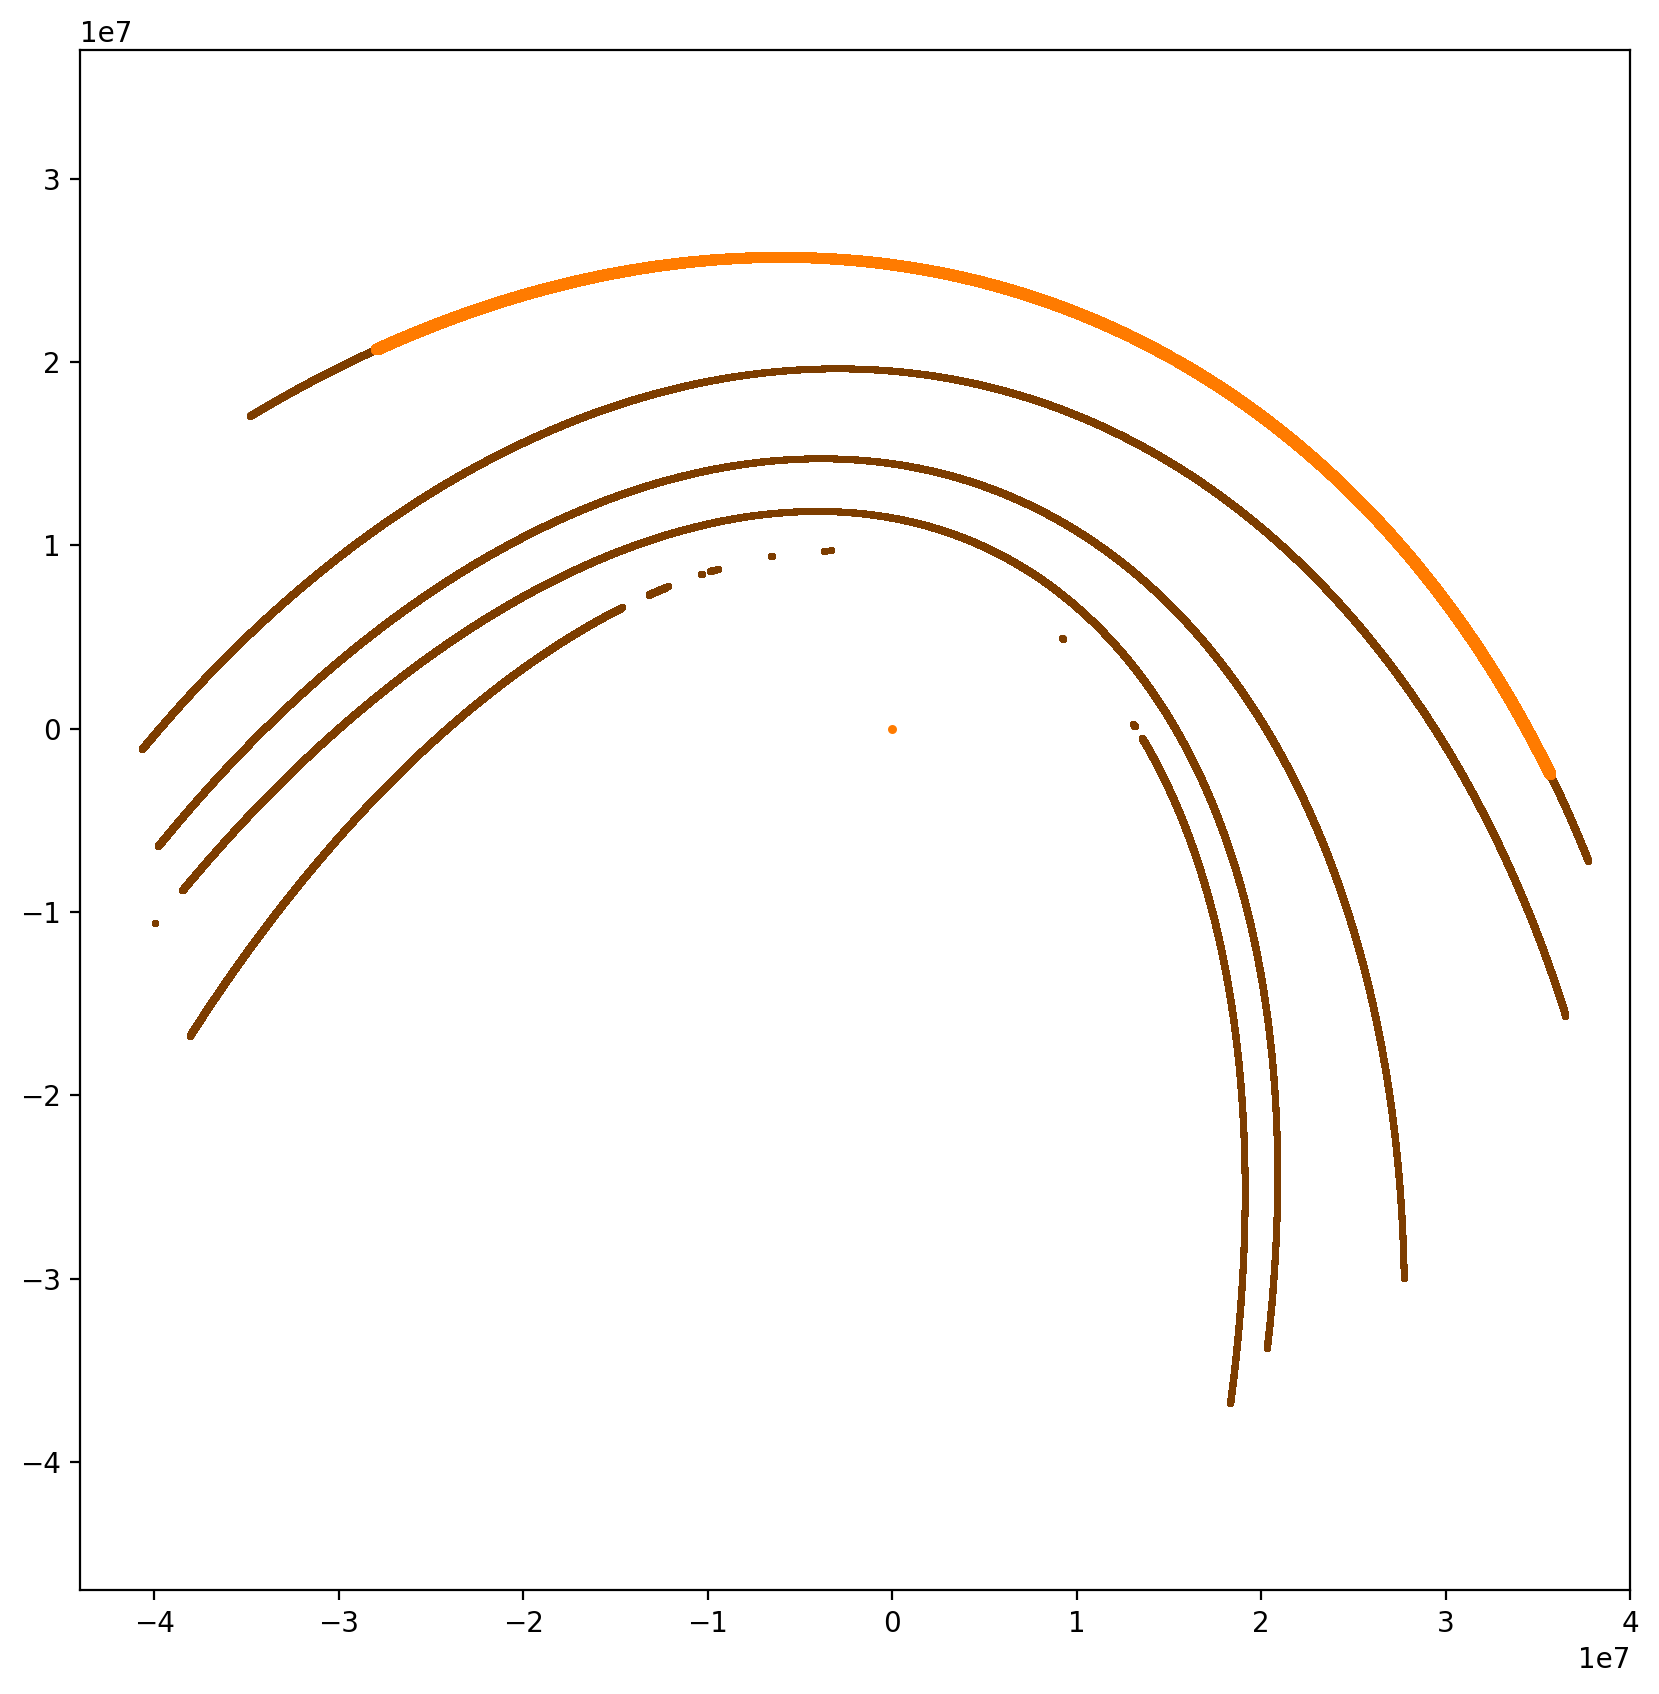

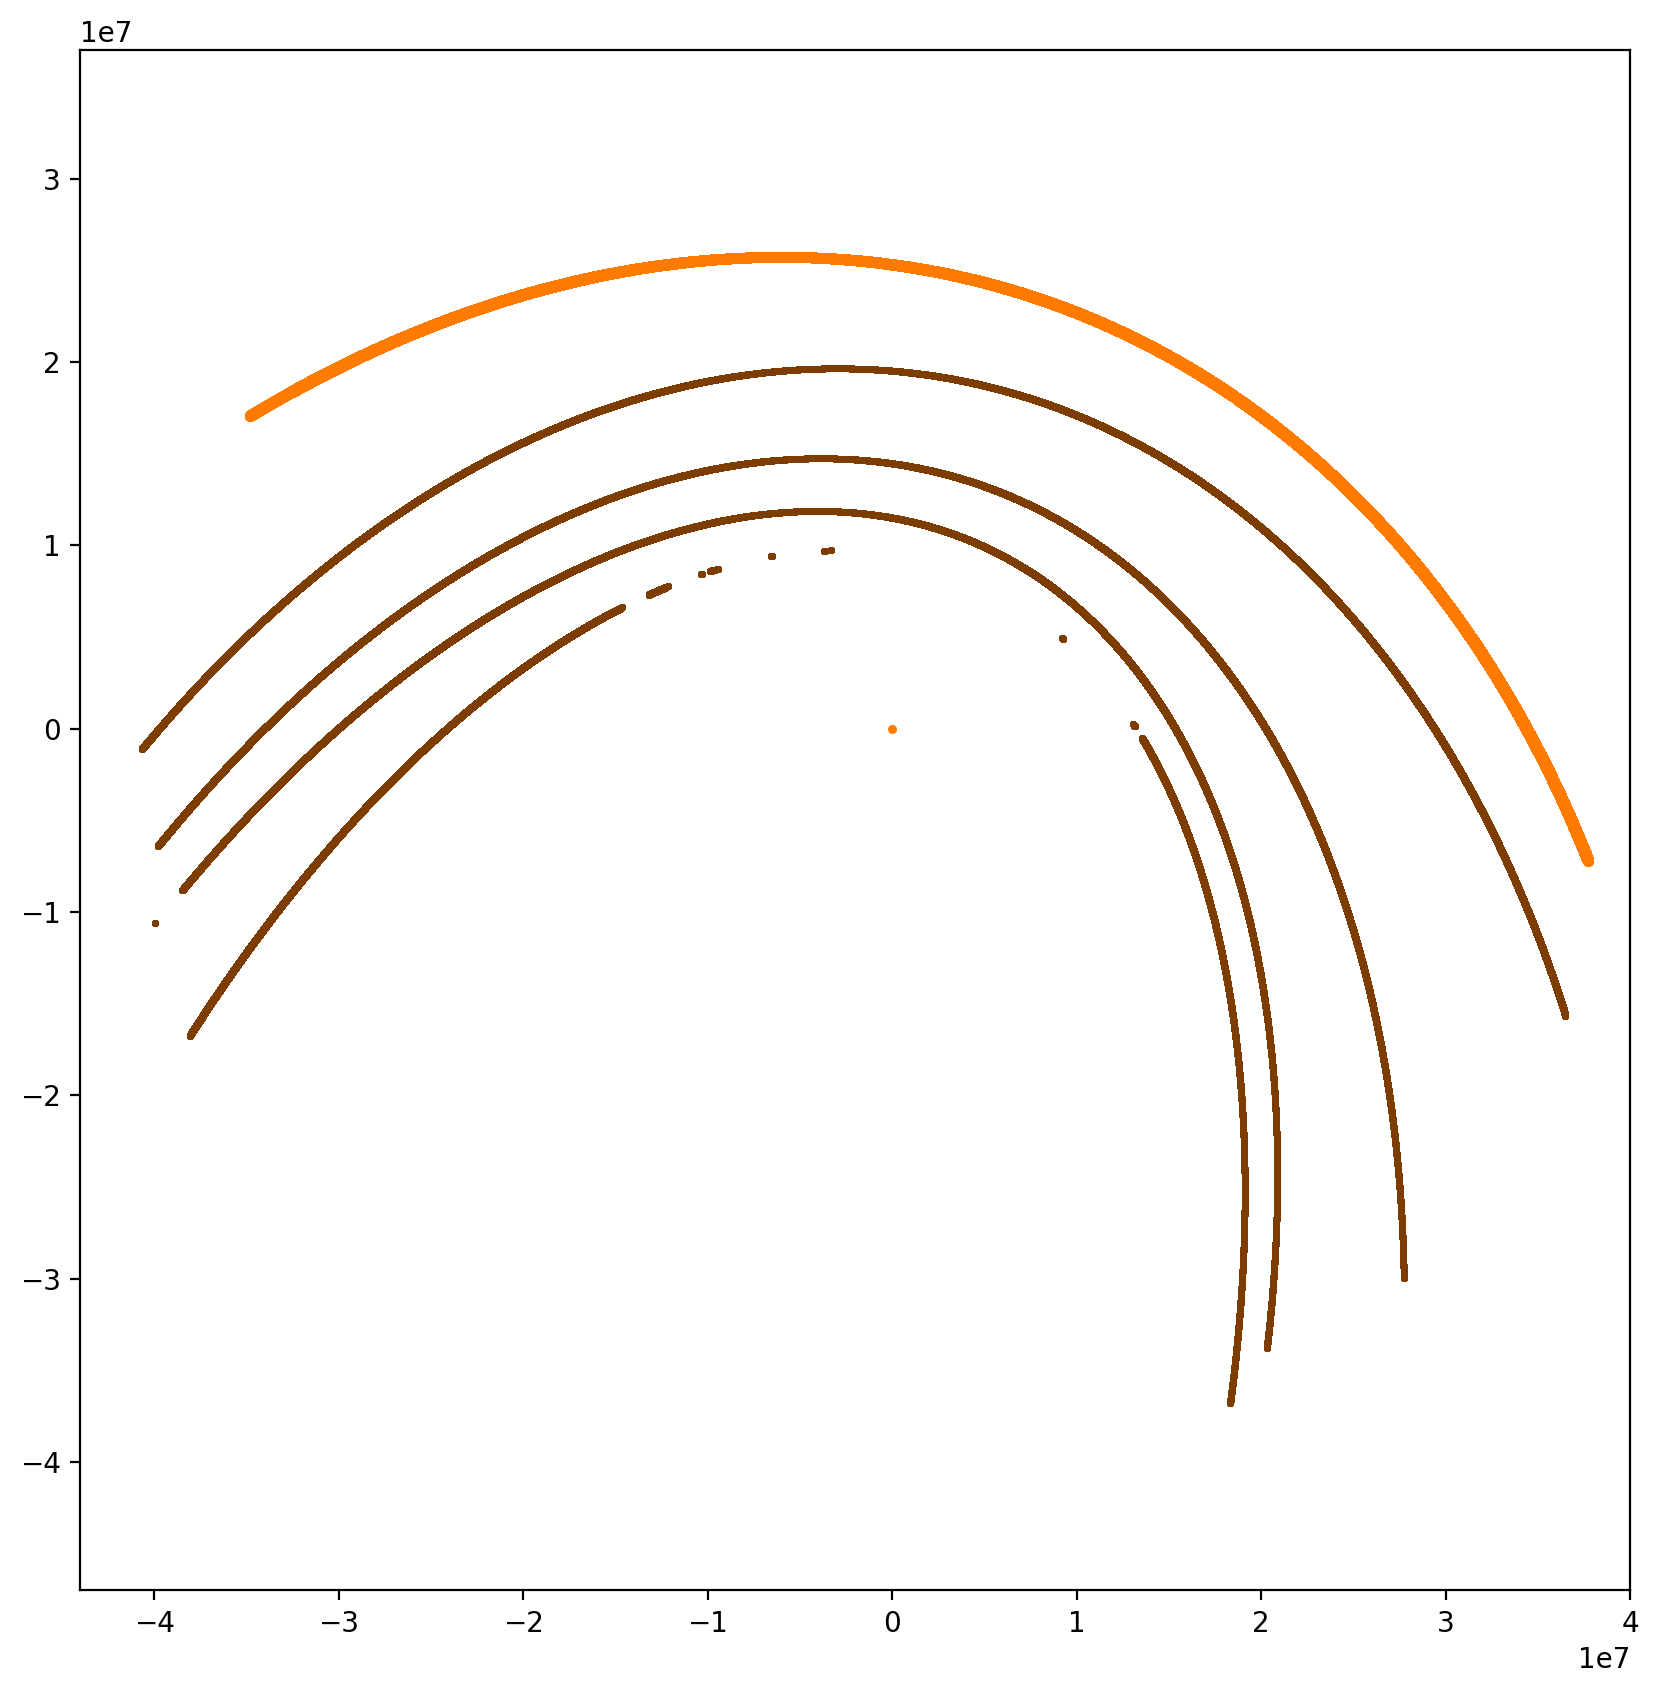

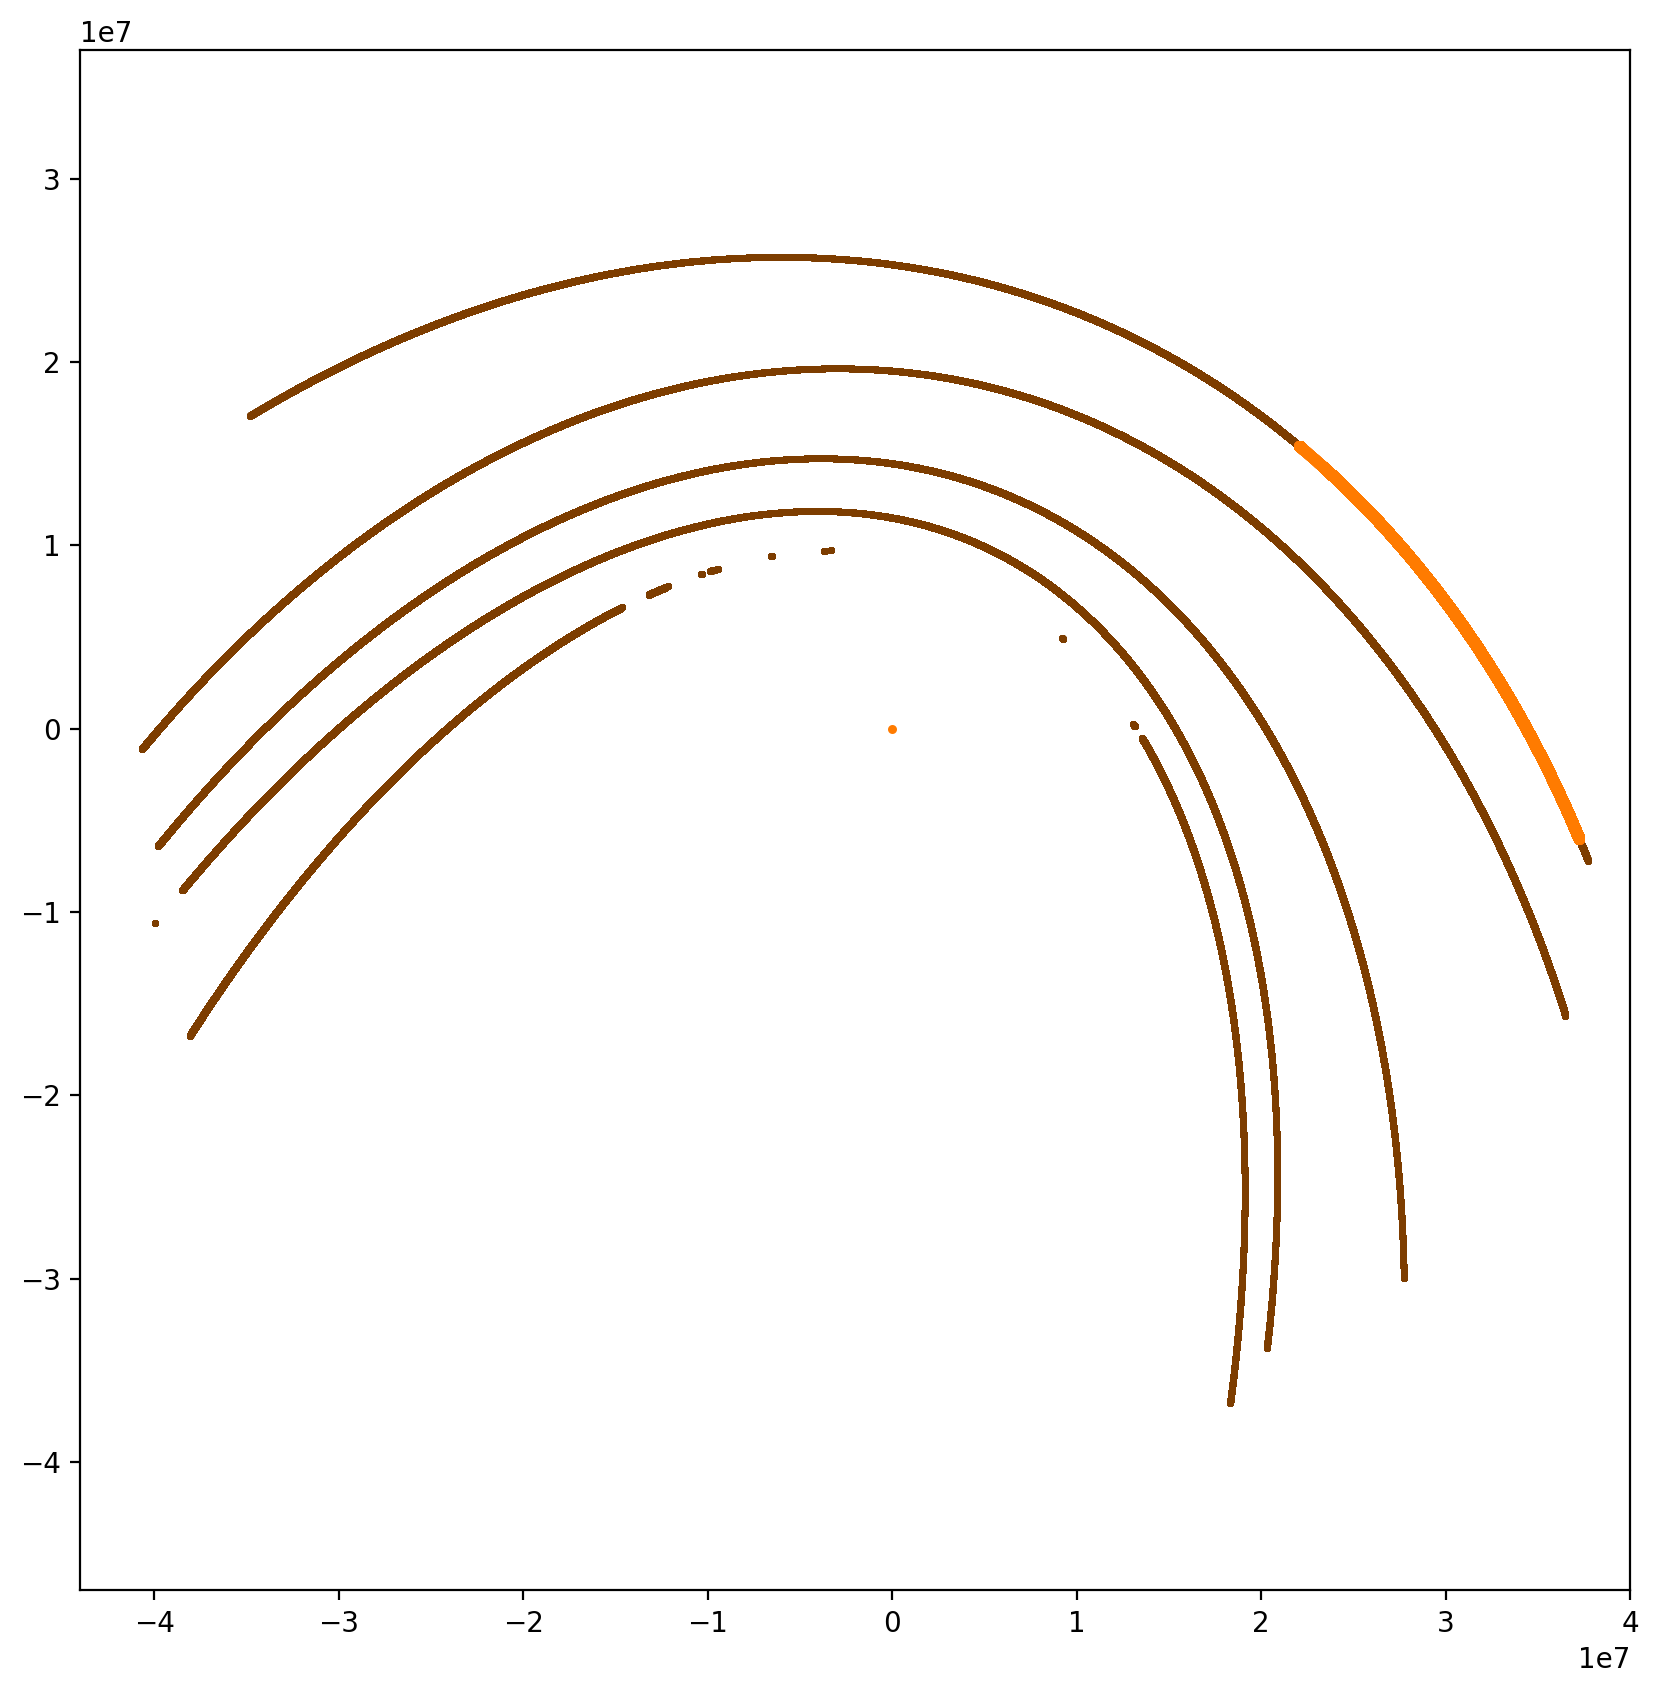

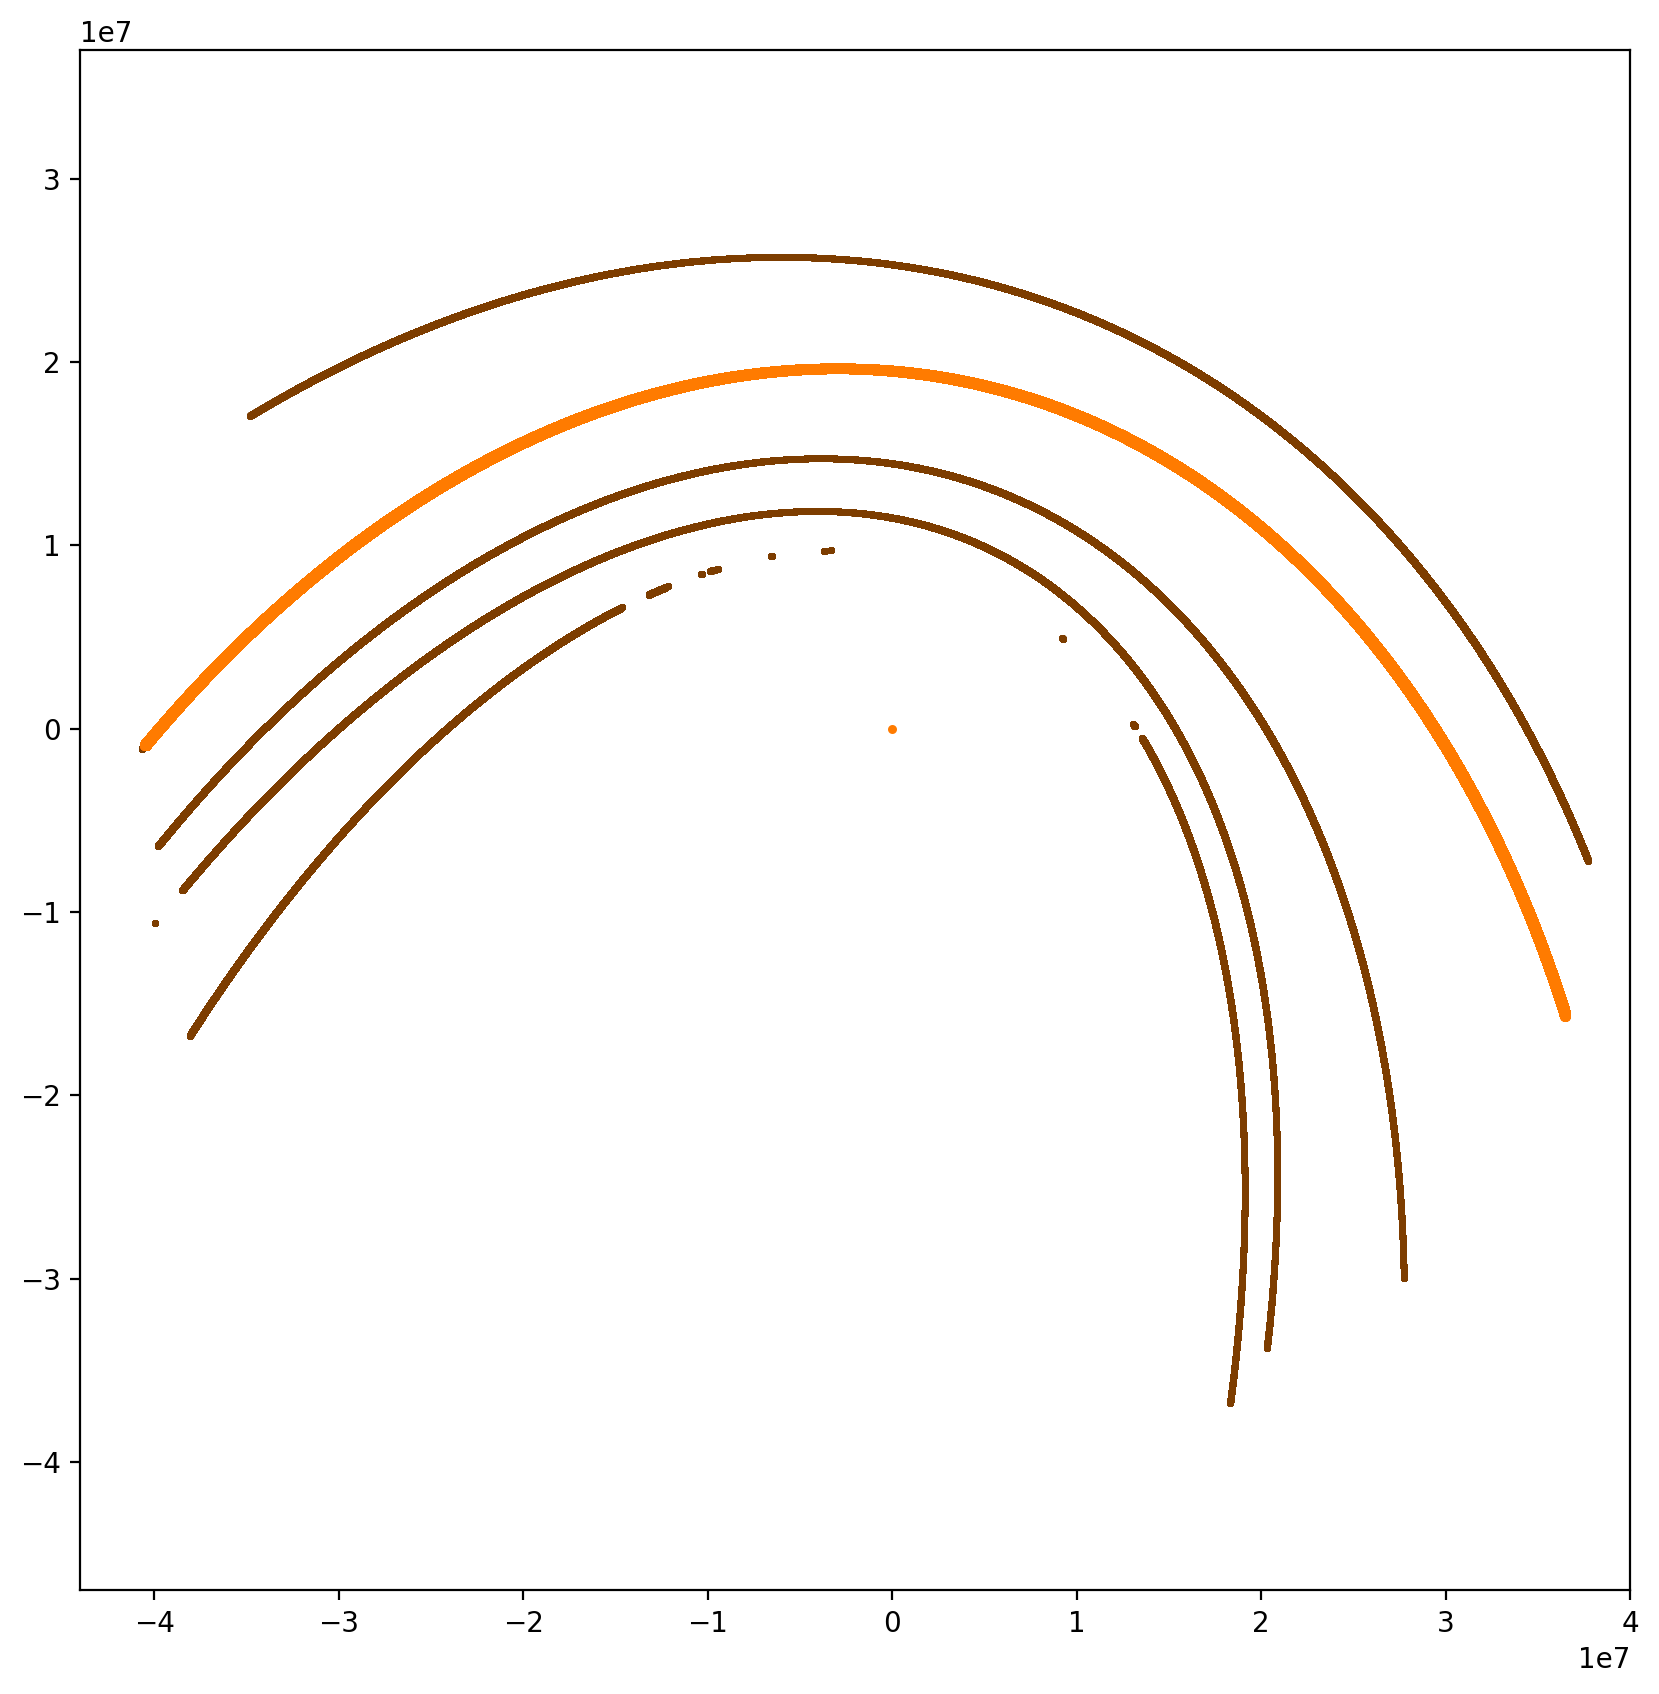

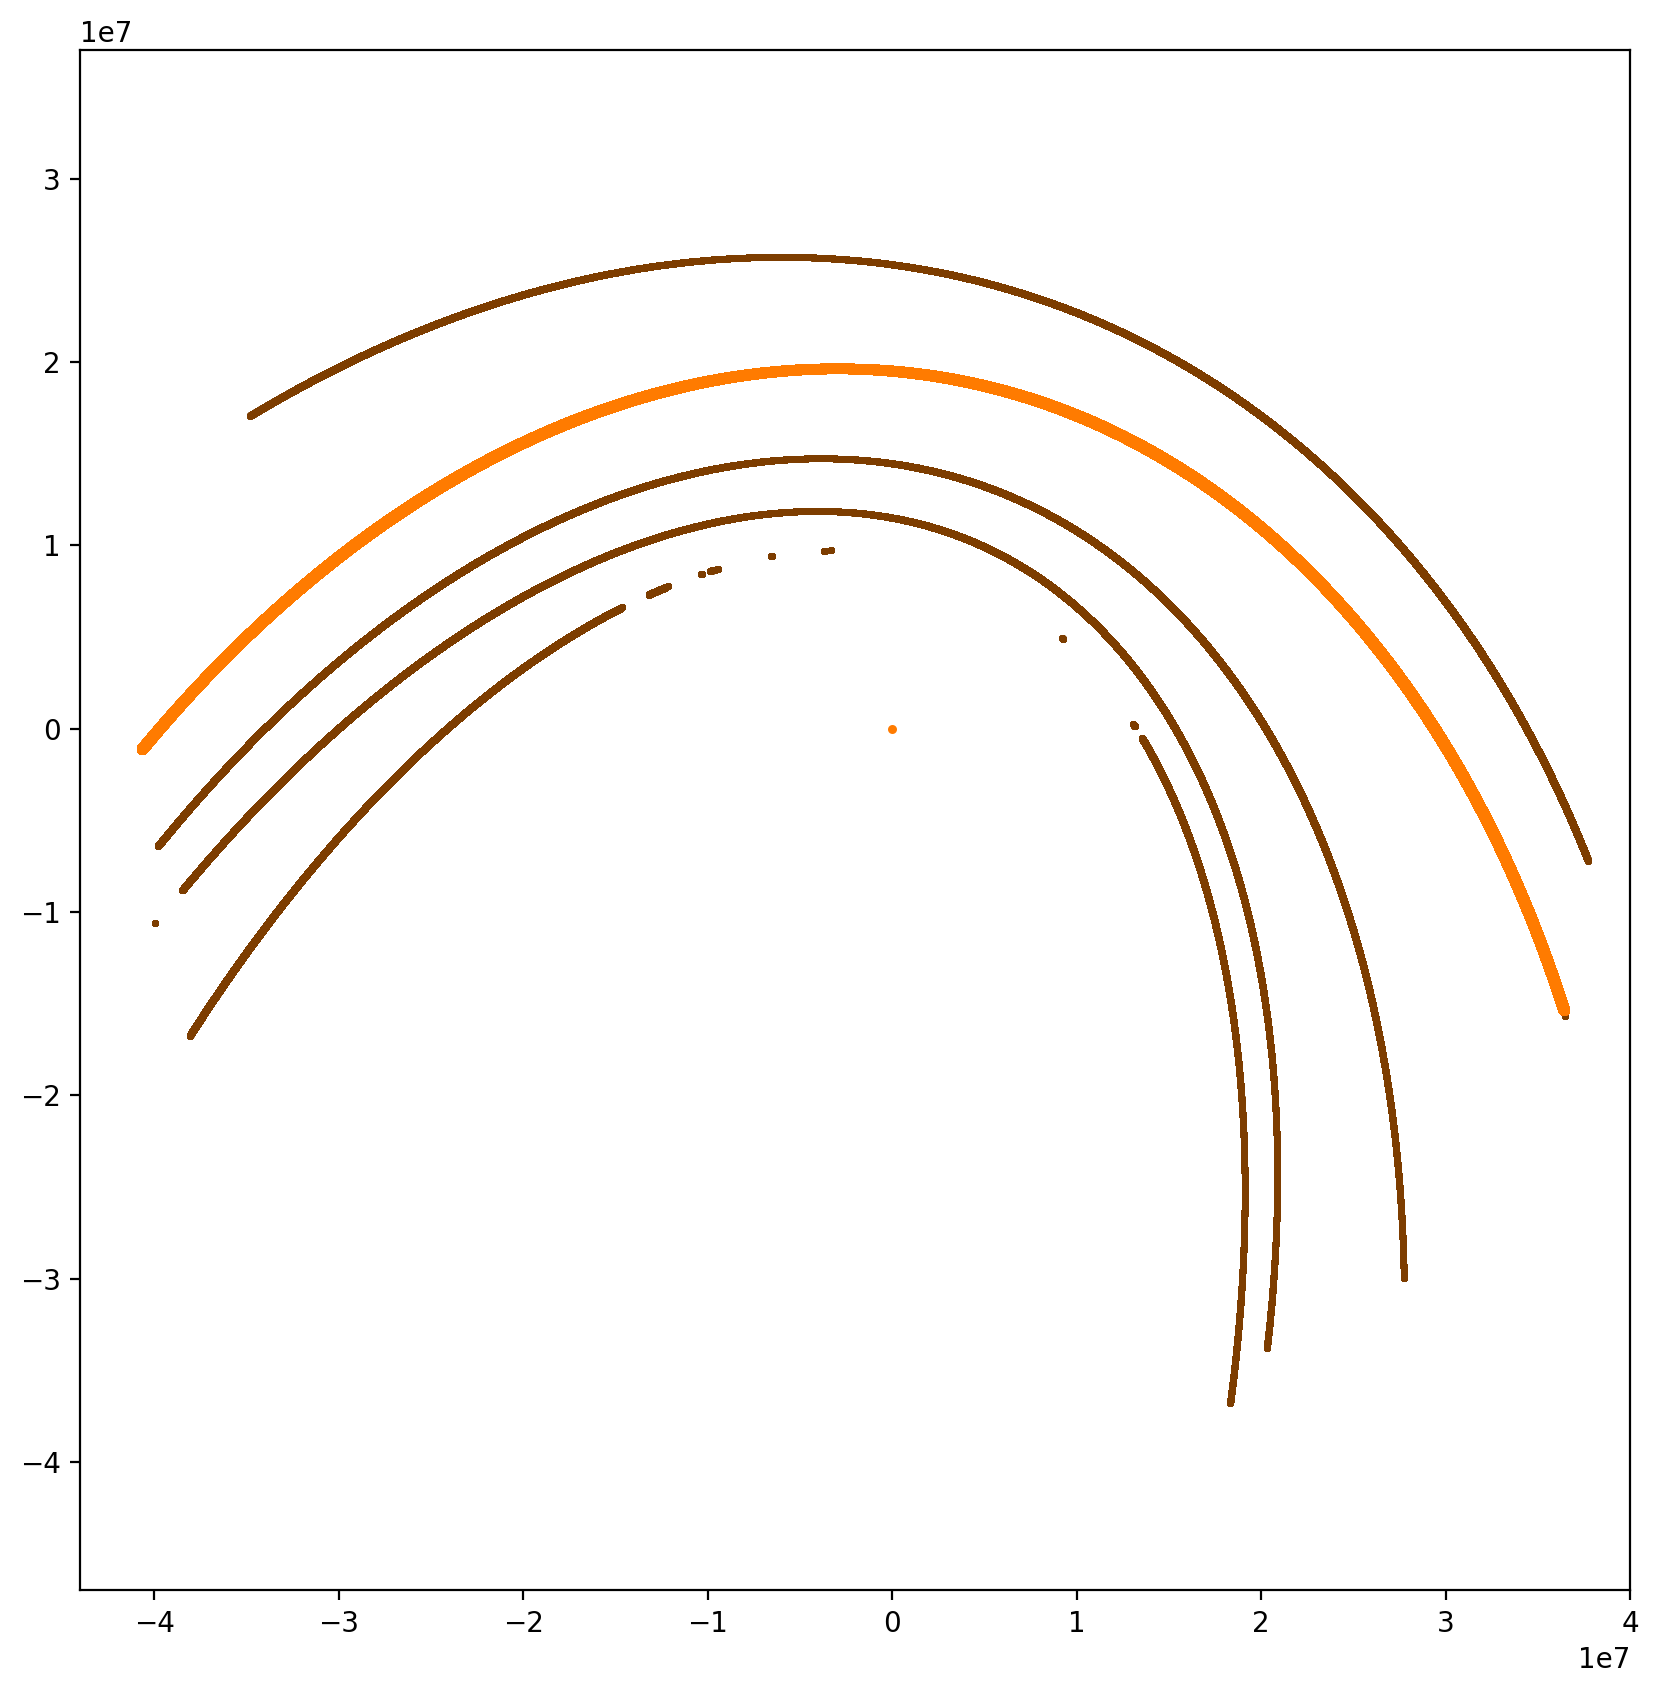

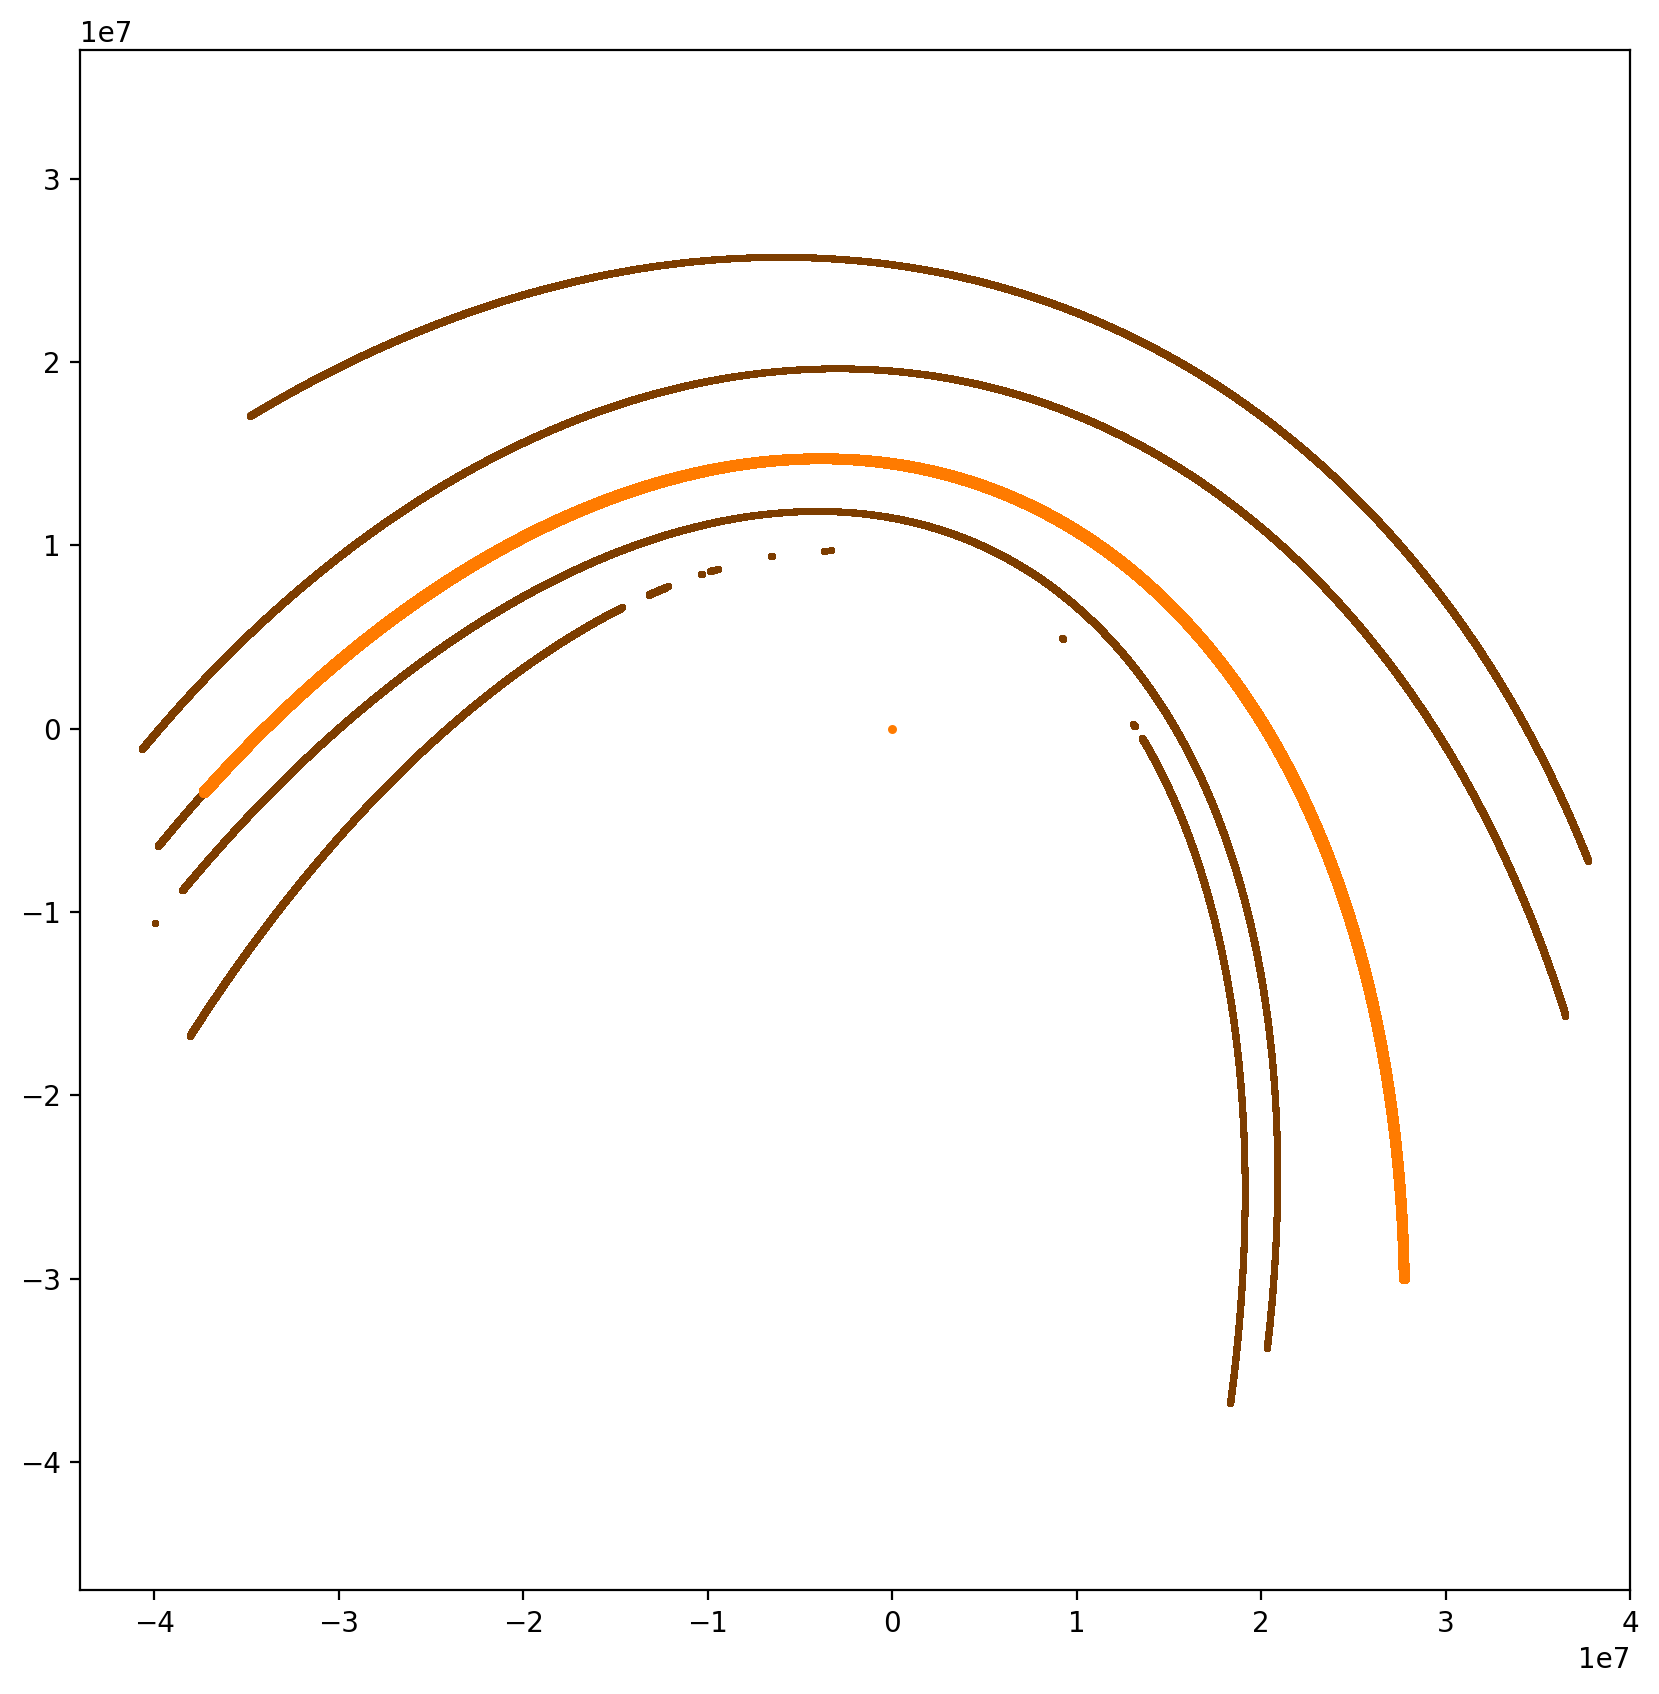

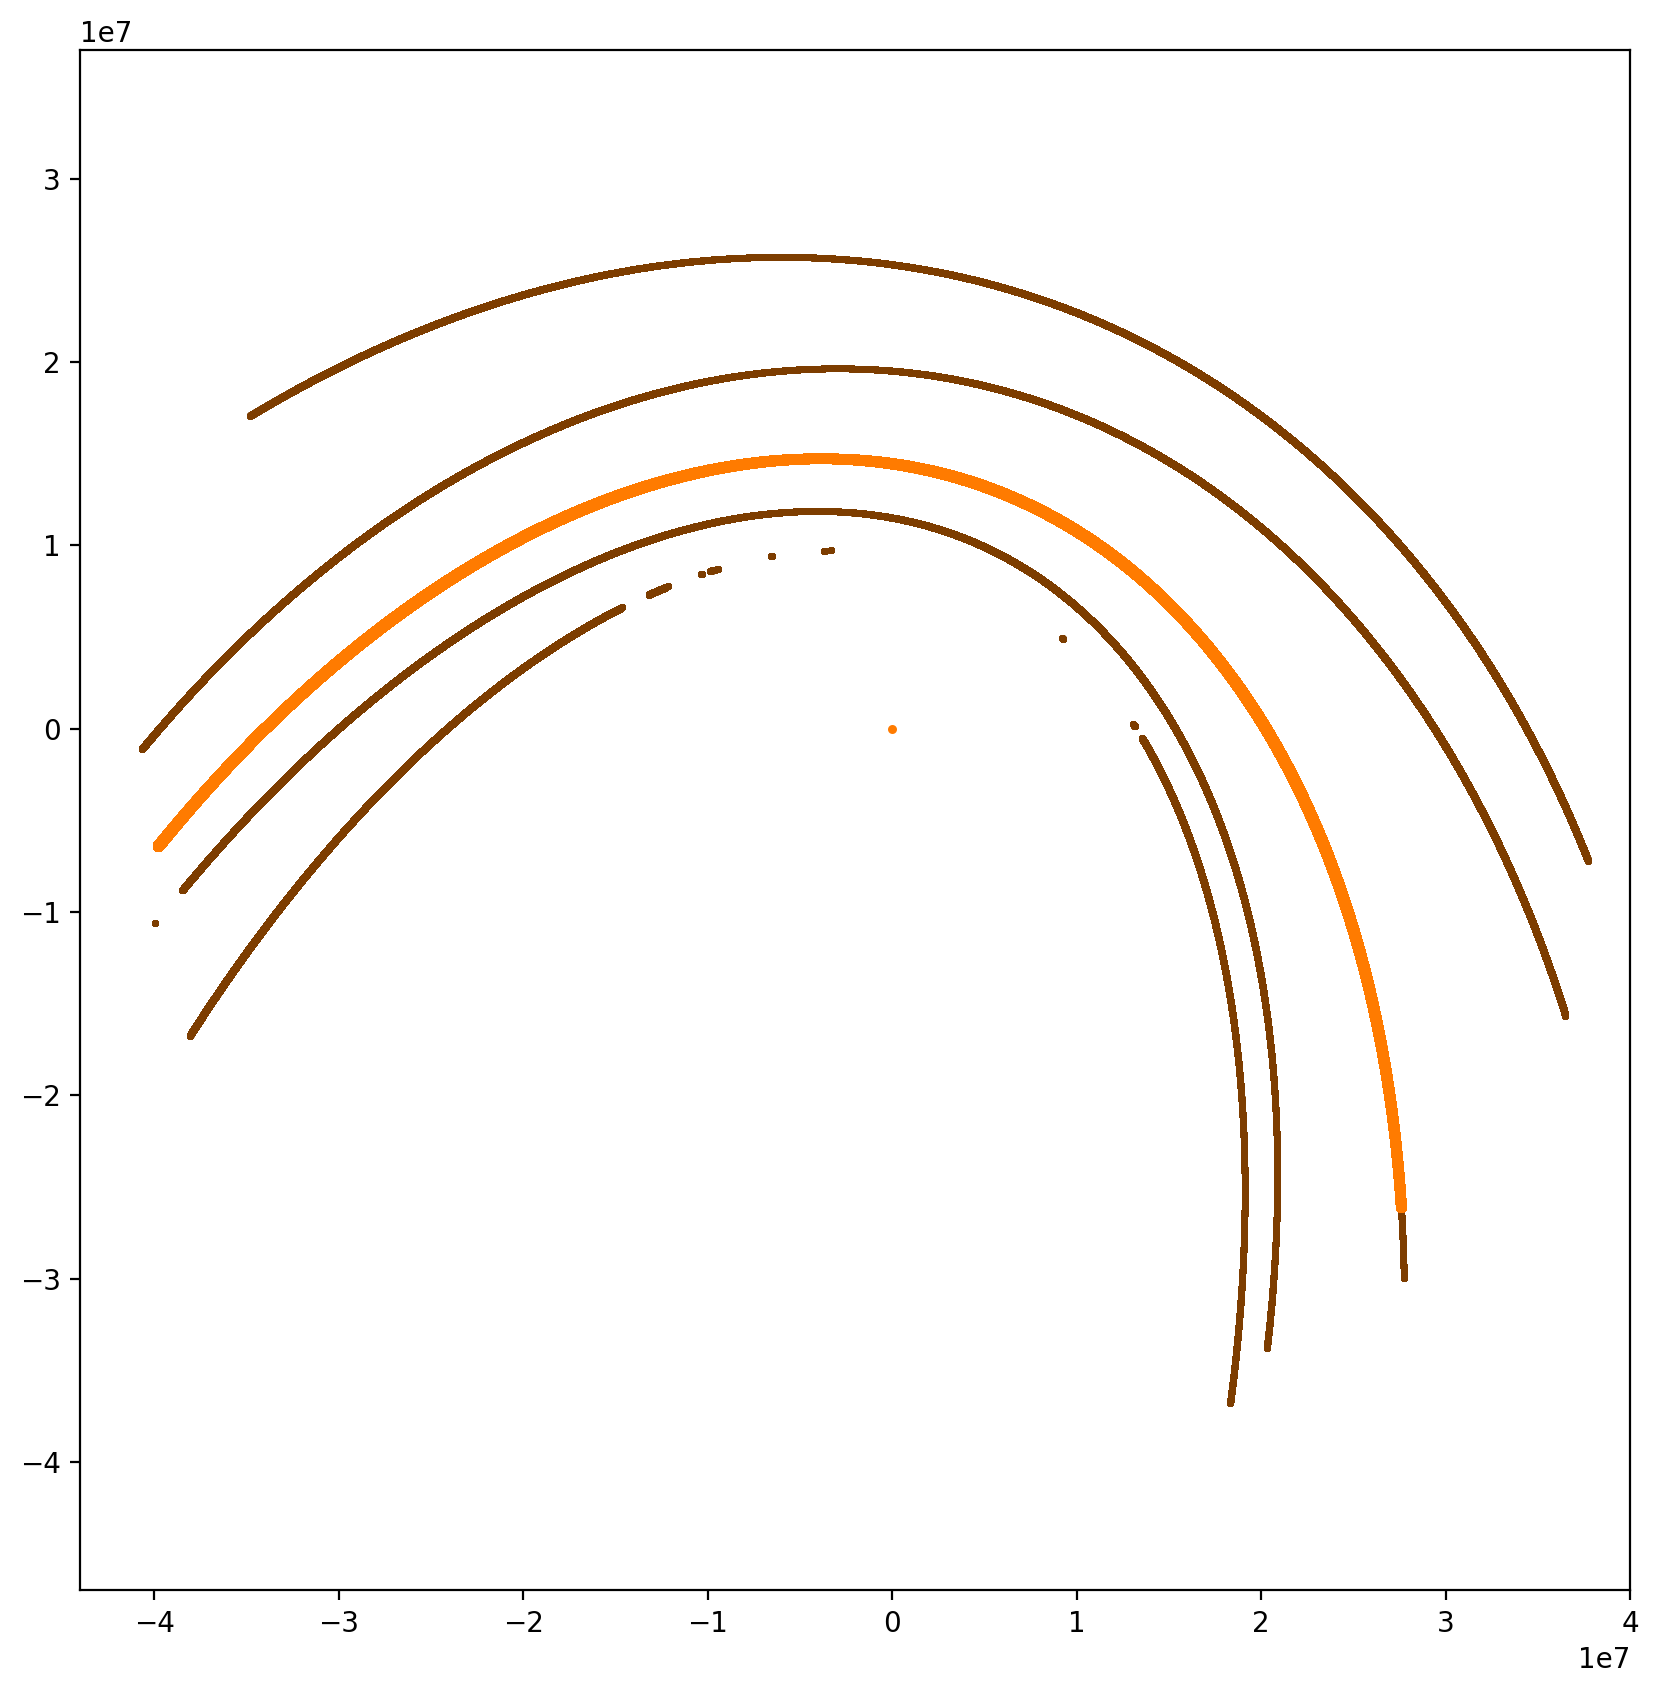

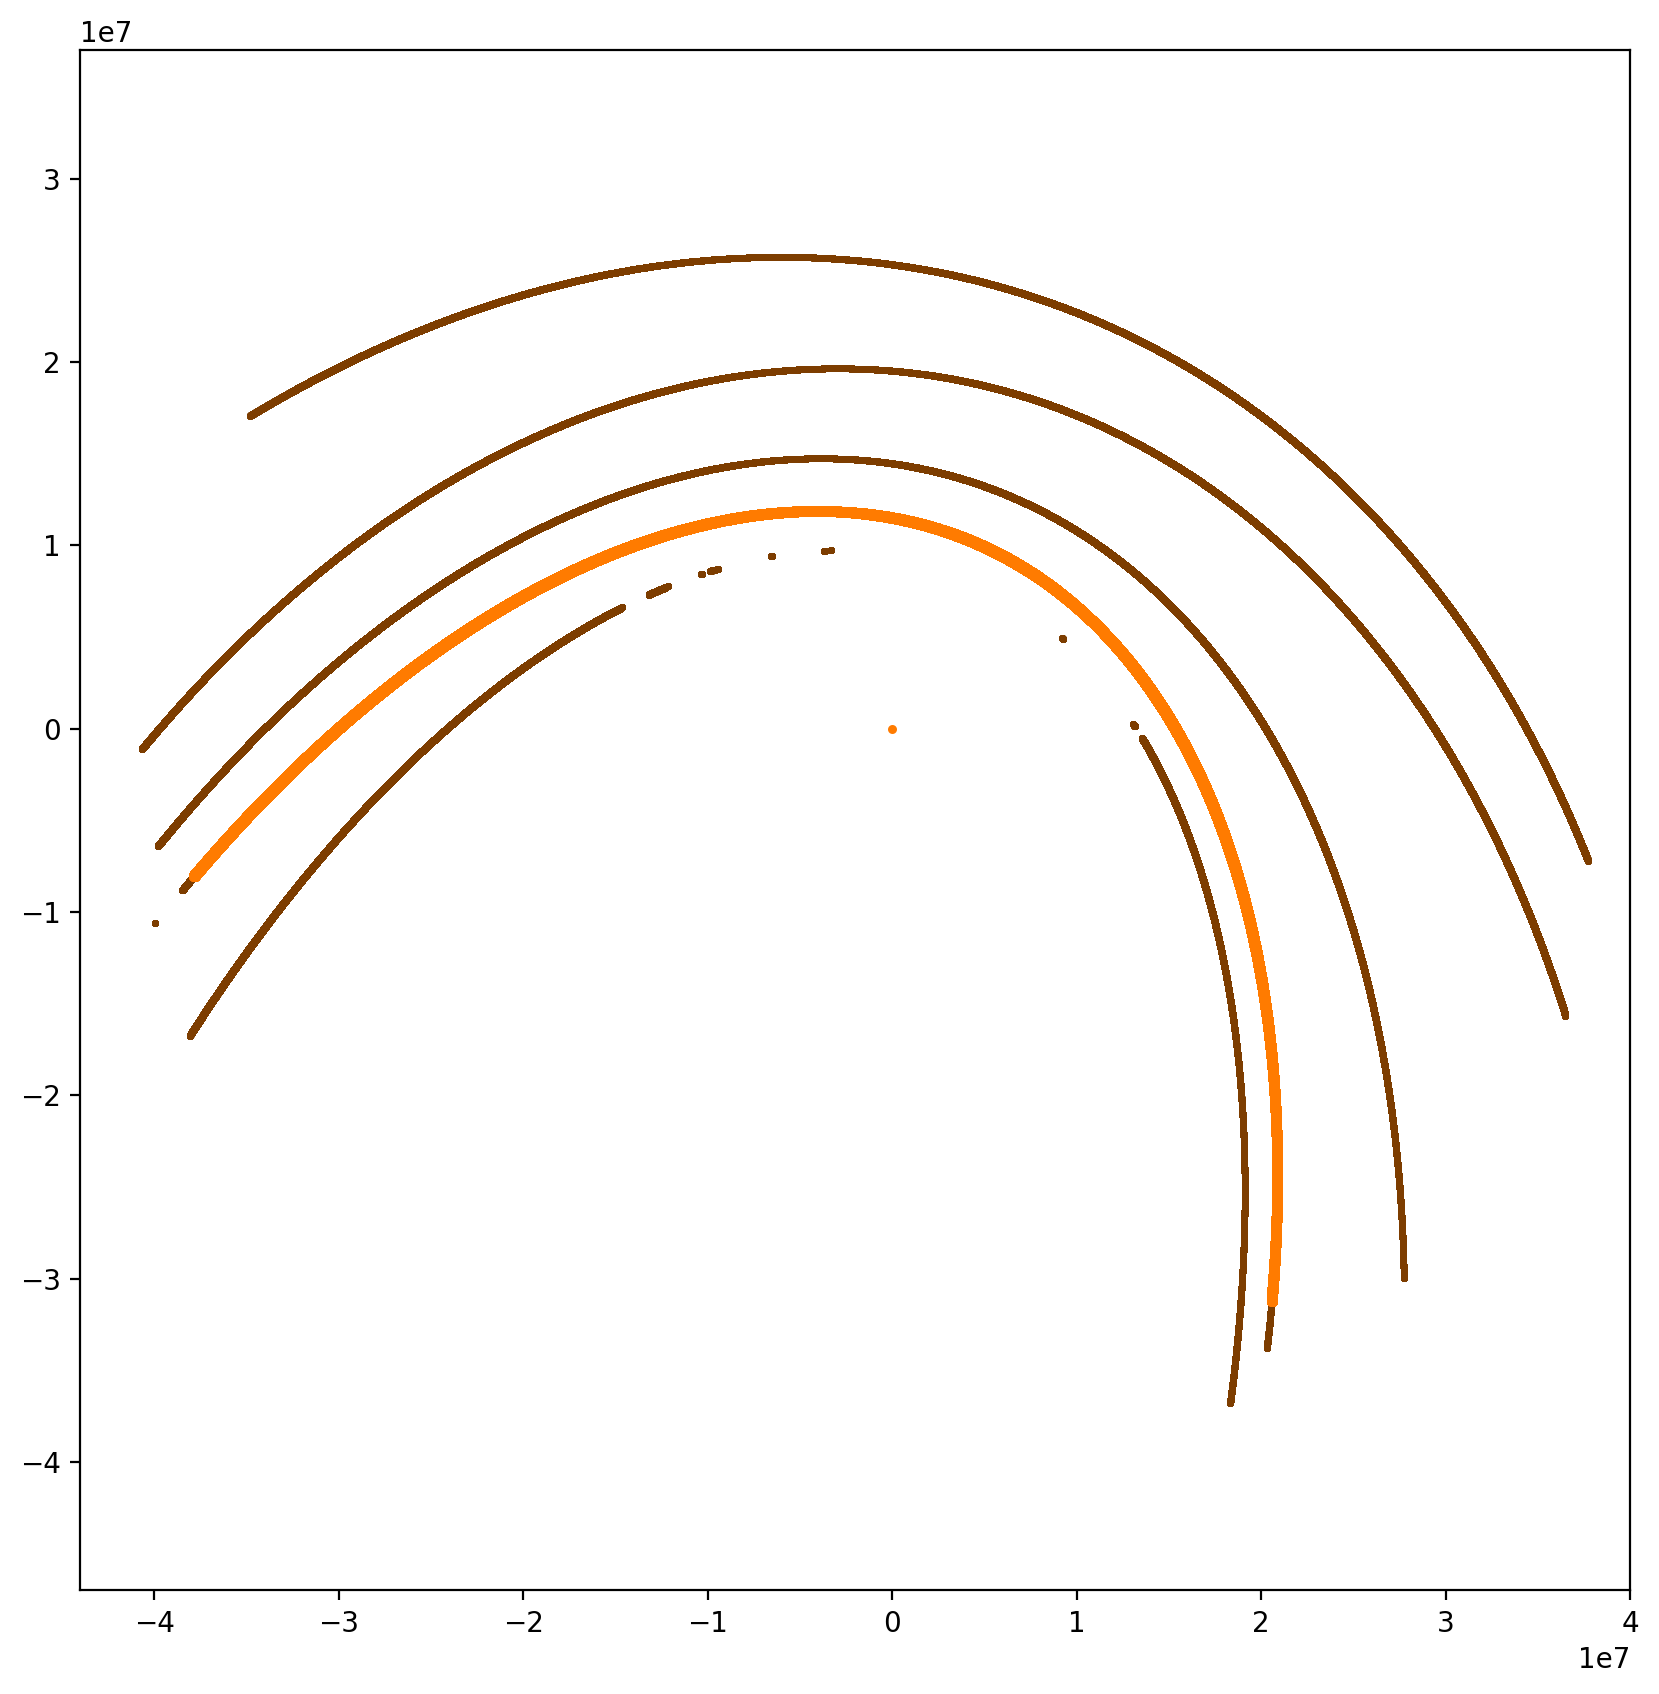

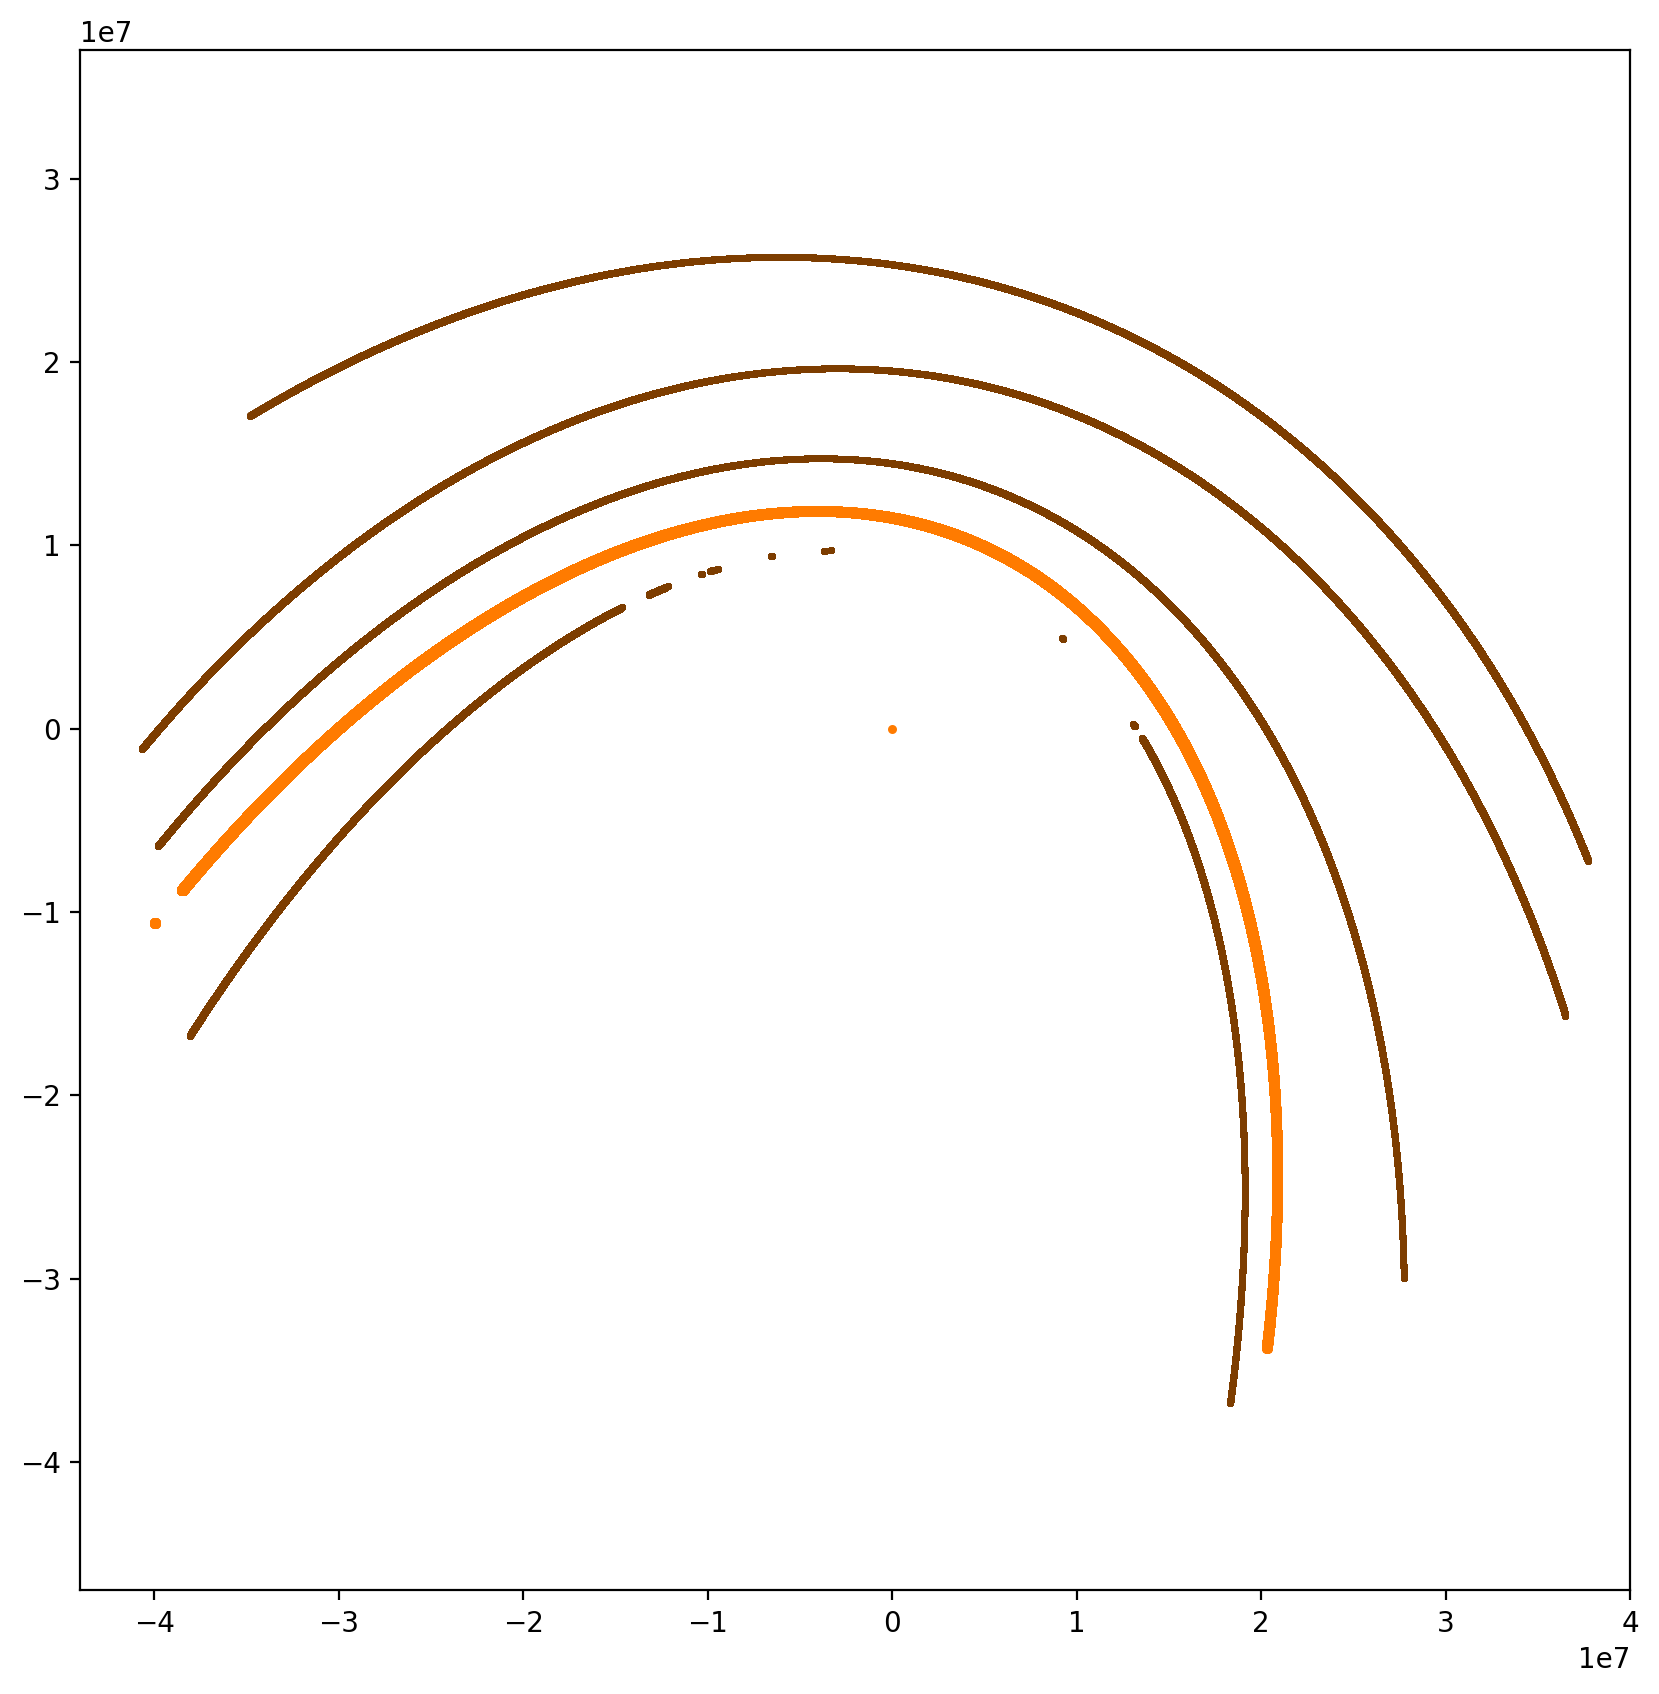

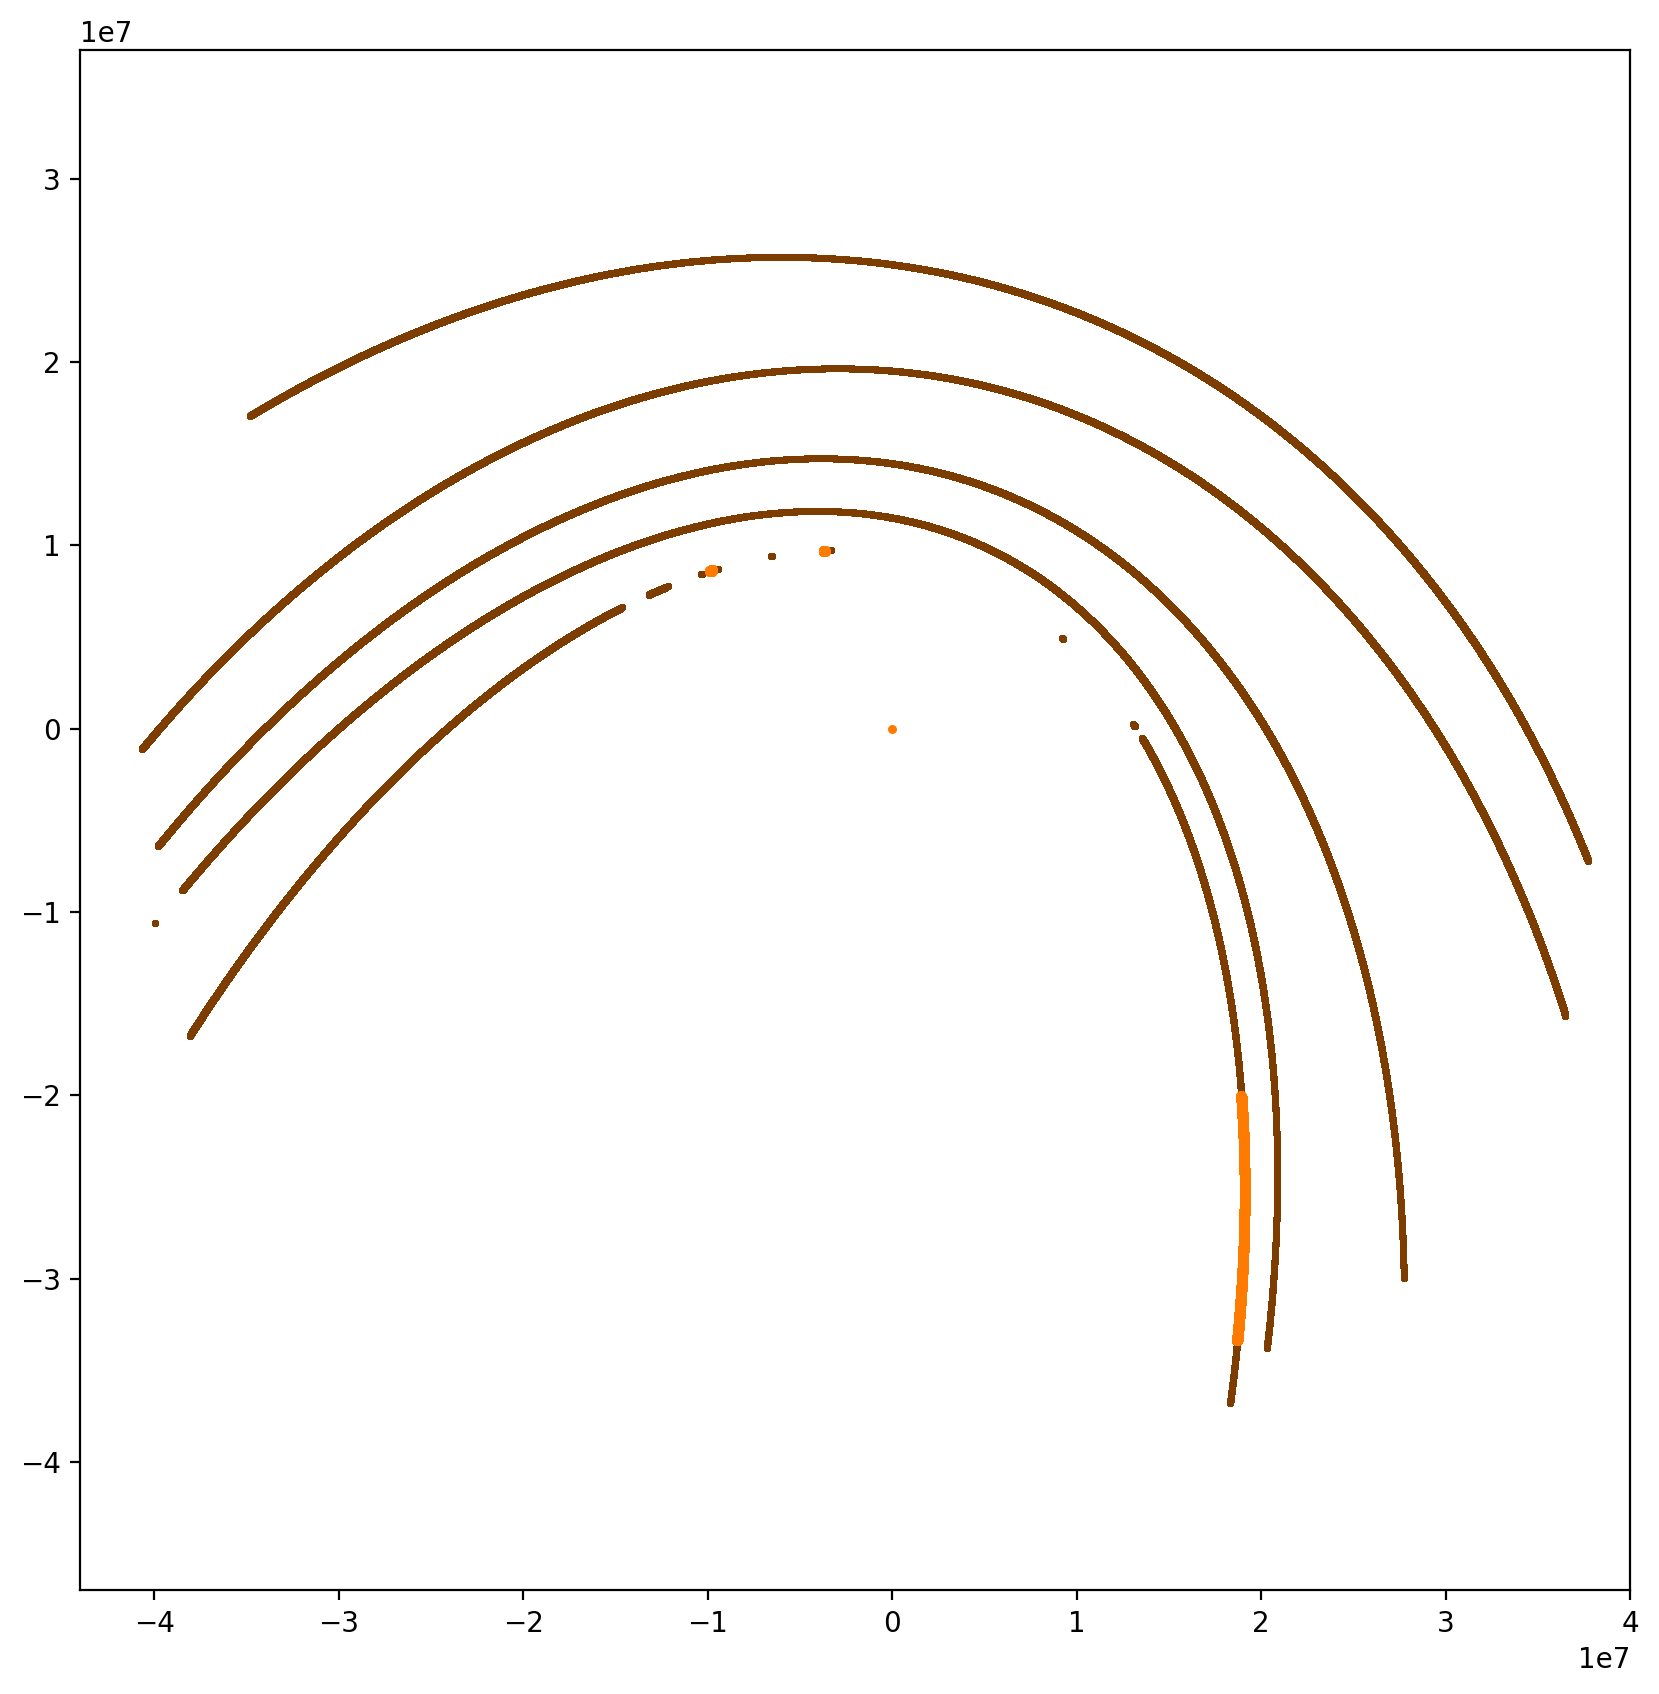

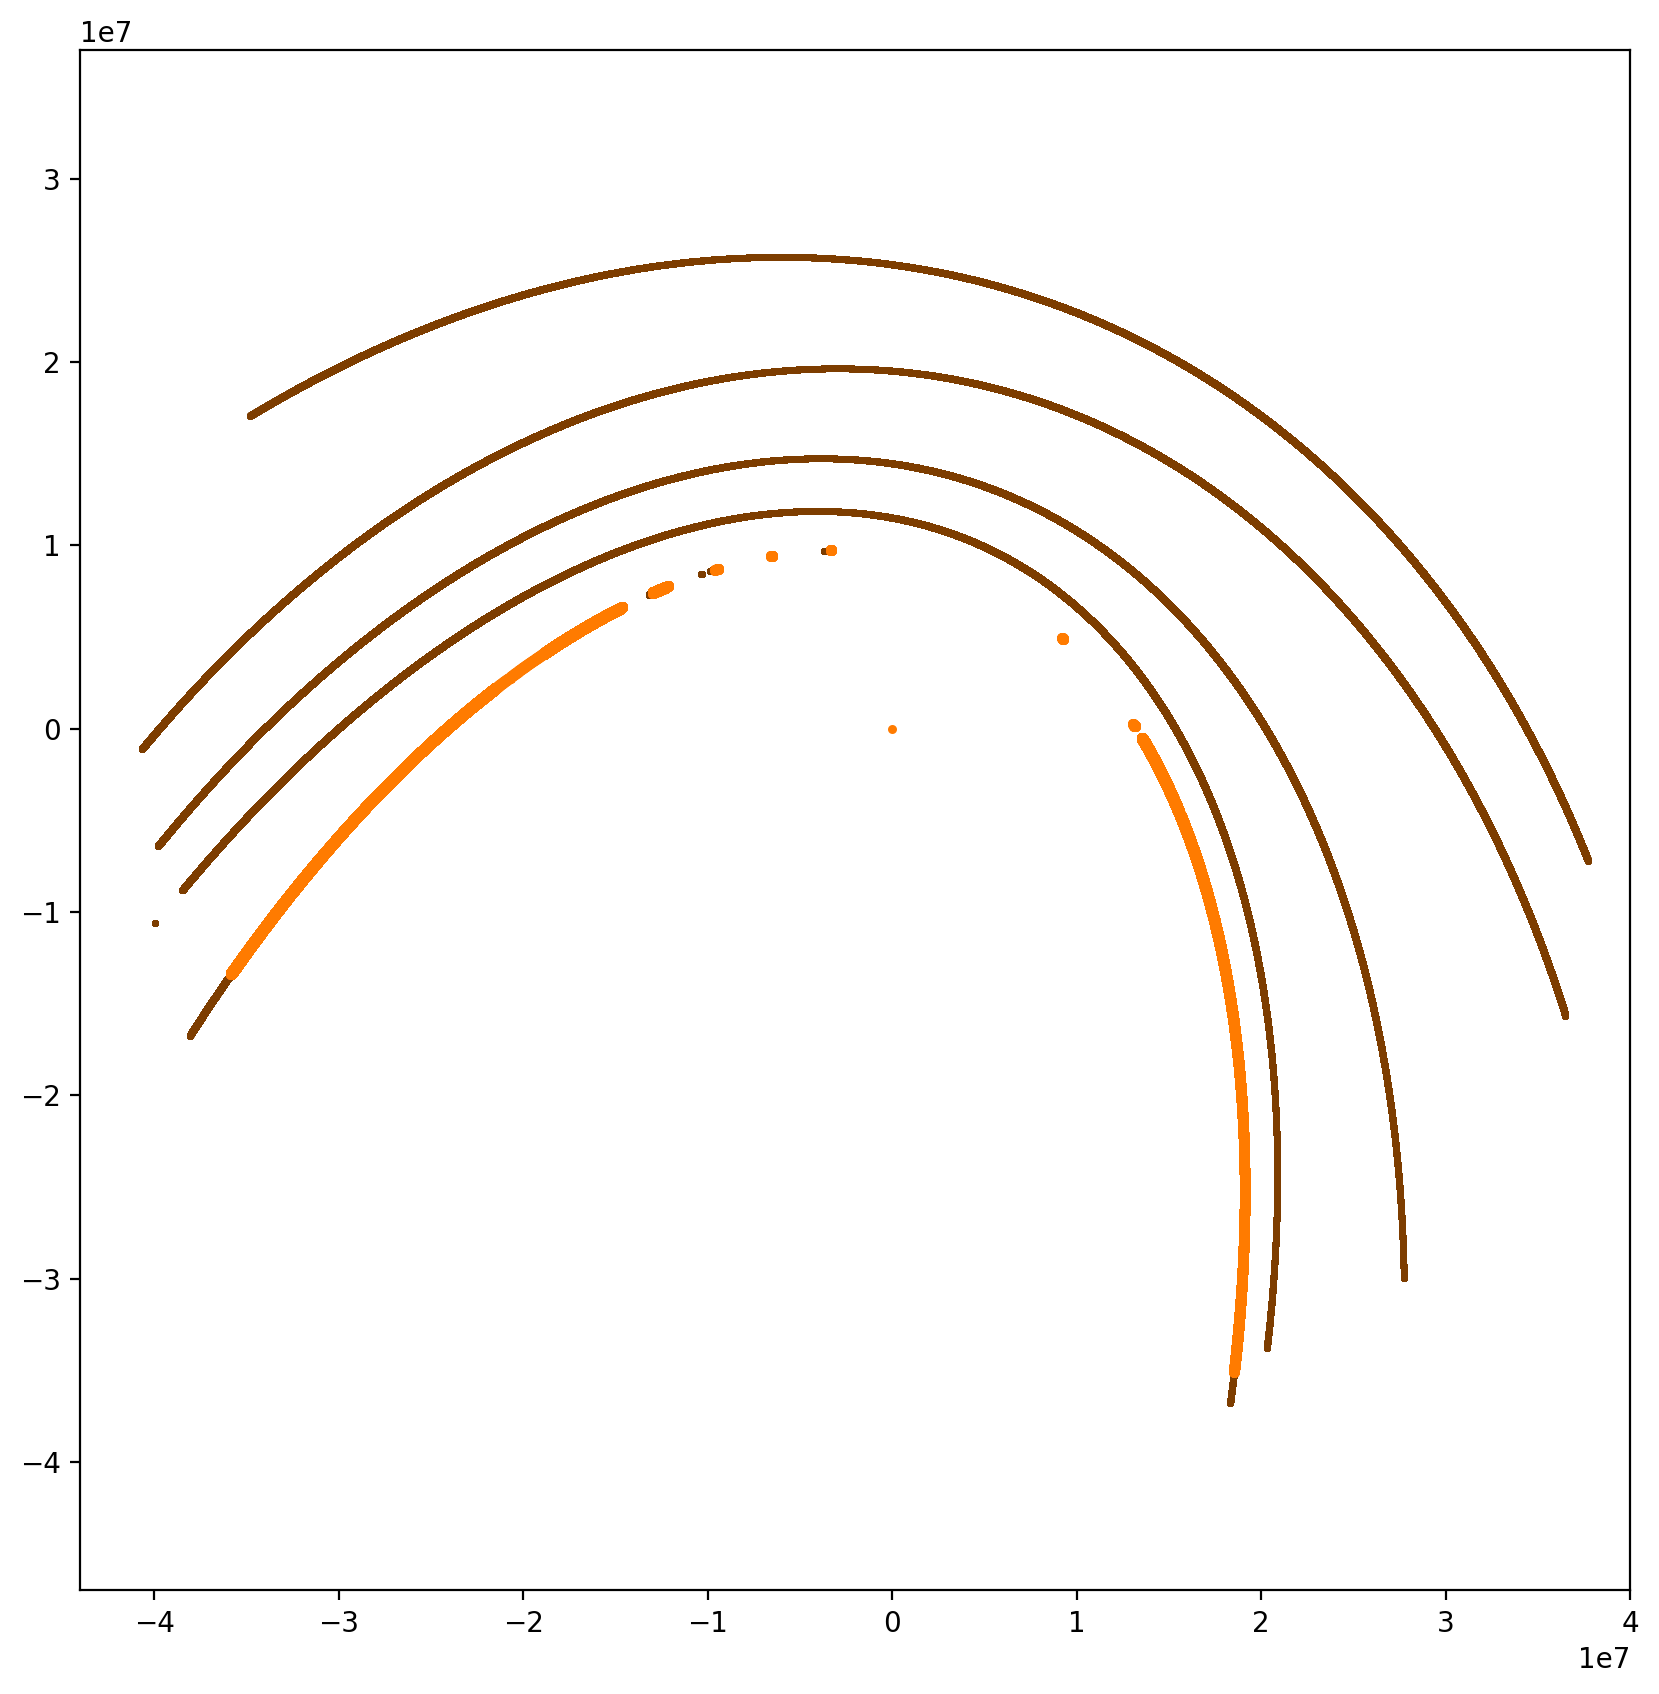

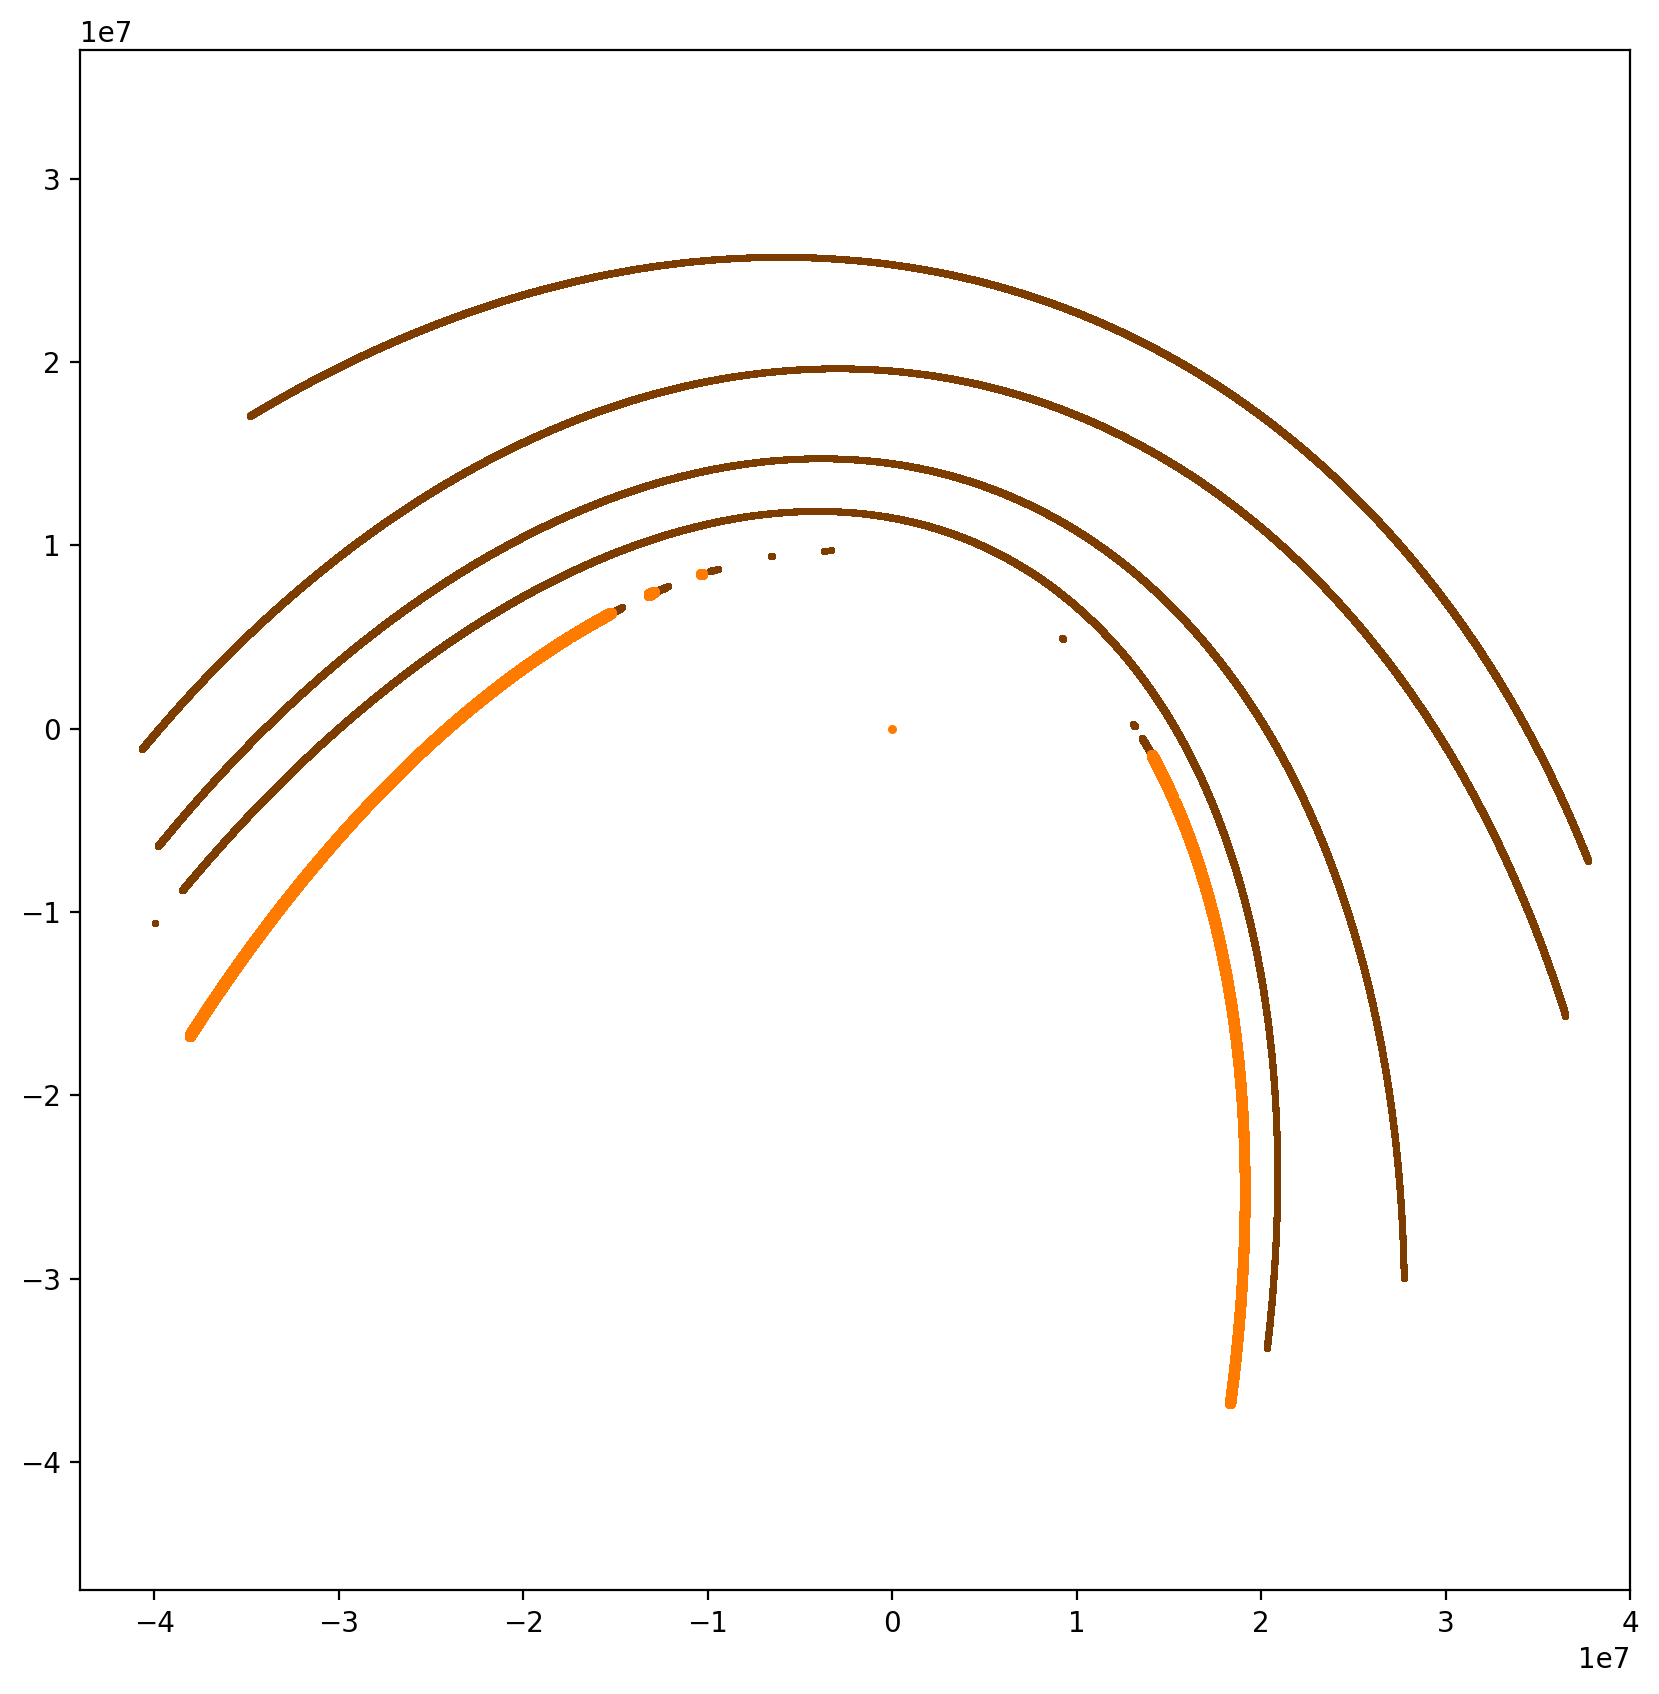

In [81]:
# Creating the location plots for the position display
NUMBEROFORBITS = 12
orbit_dates = [
['2018-11-01', '2018-11-11'],
['2019-03-30', '2019-04-11'],
['2019-08-27', '2019-09-08'],
['2020-01-23', '2020-02-05'],
['2020-06-01', '2020-06-14'],
['2020-09-21', '2020-10-03'],
['2021-01-12', '2021-01-24'],
['2021-04-24', '2021-05-05'],
['2021-08-04', '2021-08-16'],
['2021-11-16', '2021-11-27'],
['2022-02-20', '2022-03-03'],
['2022-05-27', '2022-06-08'],
]

for highlight in range(NUMBEROFORBITS):
    plt.figure(figsize=(10, 10), dpi=200)
    plt.xlim([-4.4e7, 4e7])
    plt.ylim([-4.7e7, 3.7e7])
    for ORB in range(NUMBEROFORBITS):
        # Loads orbit data
        spc_vars = pyspedas.psp.spc(trange=orbit_dates[ORB], datatype='l3i', level='l3', varnames = ['sc_pos_HCI'], notplot=True, no_update=False)
        plt.scatter(spc_vars['psp_spc_sc_pos_HCI']['y'][:,0], spc_vars['psp_spc_sc_pos_HCI']['y'][:,1], s=2, c = '#7d3d00')
    # Graphs highlighted orbit on top
    spc_vars = pyspedas.psp.spc(trange=orbit_dates[highlight], datatype='l3i', level='l3', varnames = ['sc_pos_HCI'], notplot=True, no_update=False)
    plt.scatter(spc_vars['psp_spc_sc_pos_HCI']['y'][:,0], spc_vars['psp_spc_sc_pos_HCI']['y'][:,1], s=8, c = '#ff7b00')
    plt.scatter(np.array([0]), np.array([0]), s=5, c = '#ff7b00')
    plt.savefig(f'public/orbit_plot2_{highlight+1}.png', transparent = True)

## SPAN-e Data Processing

In [10]:
# Processing SWEAP-e data and exporting text files
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

orbit_dates = [
['2018-11-01', '2018-11-11'],
['2019-03-30', '2019-04-10'],
['2019-08-27', '2019-09-07'],
['2020-01-23', '2020-02-04'],
['2020-06-01', '2020-06-13'],
['2020-09-21', '2020-10-02'],
['2021-01-12', '2021-01-23'],
['2021-04-24', '2021-05-04'],
['2021-08-04', '2021-08-15'],
['2021-11-16', '2021-11-26'],
['2022-02-20', '2022-03-02'],
['2022-05-27', '2022-06-07'],
]
# Estimations of the average energies (eV) for the 32 different electron energy bins obtained from the graph above
energy_bins = [2,2.6,3.3,4.2,5.1,6.1,7.9,9.9,12.5,15,19,24,29,36,45,56,70,88,112,133,175,212,257,333,400,490,600,780,950,1200,1500,1800]
NUMORBITS = 12

for orbit in range(1, NUMORBITS+1):
    spe_vars = pyspedas.psp.spe(trange=orbit_dates[orbit-1], datatype='spa_sf1_32e', level='l2', notplot=True, time_clip=False)
    t2 = spe_vars['psp_spe_EFLUX']['x']
    # Total Electrons
    totalelectrons = []
    for row in spe_vars['psp_spe_EFLUX']['y']:
        total = 0
        for i in range(32):
            total += row[i] / energy_bins[i]
        totalelectrons.append(total)
    with open(f"sweap_data/sweap_txt_data/spane_orbit{orbit}.txt", 'w') as output:
        for i in range(1, t2.shape[0]):
            outstring = ""
            n = i
            if t2[i].minute != t2[i-1].minute : #if t1[i].minute - t1[i-1].minute != 1 and t1[i].minute != 0:
                # Date
                outstring += t2[i].strftime('%Y%m%d_%H%M') + ", "
                # Electron Energies 
                for energyval in spe_vars['psp_spe_EFLUX']['y'][i]:
                    outstring += f"{energyval}, "
                # Total Electrons
                while np.isnan(totalelectrons[n]):
                    n += 1
                outstring += f"{totalelectrons[n]}"
                n = i
                output.write(outstring + "\n")

04-Jan-23 22:09:22: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2018/
04-Jan-23 22:09:22: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2018/psp_swp_spa_sf1_l2_32e_20181101_v03.cdf
04-Jan-23 22:09:22: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2018/psp_swp_spa_sf1_l2_32e_20181102_v03.cdf
04-Jan-23 22:09:23: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2018/psp_swp_spa_sf1_l2_32e_20181103_v03.cdf
04-Jan-23 22:09:23: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2018/psp_swp_spa_sf1_l2_32e_20181104_v03.cdf
04-Jan-23 22:09:23: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2018/psp_swp_spa_sf1_l2_32e_20181105_v03.cdf
04-Jan-23 22:09:23: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2018/psp_swp_spa_sf1_l2_32e_20181106_v03.cdf
04-Jan-23 22:09:23: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/2018/psp_swp_spa_sf1_l2_32e_20181107_v03.cdf
04-Jan-23 22:09:23: File is current: psp_data/sweap/spe/l2/spa_sf1_32e/

04-Jan-23 22:11:52: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200127_v03.cdf
04-Jan-23 22:11:53: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200128_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200128_v03.cdf
04-Jan-23 22:11:56: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200128_v03.cdf
04-Jan-23 22:11:57: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200129_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200129_v03.cdf
04-Jan-23 22:12:00: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200129_v03.cdf
04-Jan-23 22:12:00: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200130_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf

04-Jan-23 22:14:31: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200925_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200925_v03.cdf
04-Jan-23 22:14:35: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200925_v03.cdf
04-Jan-23 22:14:35: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200926_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200926_v03.cdf
04-Jan-23 22:14:40: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200926_v03.cdf
04-Jan-23 22:14:40: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200927_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf1_l2_32e_20200927_v03.cdf
04-Jan-23 22:14:44: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2020/psp_swp_spa_sf

04-Jan-23 22:17:27: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210805_v03.cdf
04-Jan-23 22:17:27: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210806_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210806_v03.cdf
04-Jan-23 22:17:31: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210806_v03.cdf
04-Jan-23 22:17:31: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210807_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210807_v03.cdf
04-Jan-23 22:17:36: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210807_v03.cdf
04-Jan-23 22:17:36: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf1_l2_32e_20210808_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2021/psp_swp_spa_sf

04-Jan-23 22:20:04: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf1_l2_32e_20220224_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf1_l2_32e_20220224_v03.cdf
04-Jan-23 22:20:08: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf1_l2_32e_20220224_v03.cdf
04-Jan-23 22:20:09: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf1_l2_32e_20220225_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf1_l2_32e_20220225_v03.cdf
04-Jan-23 22:20:12: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf1_l2_32e_20220225_v03.cdf
04-Jan-23 22:20:13: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf1_l2_32e_20220226_v03.cdf to psp_data/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf1_l2_32e_20220226_v03.cdf
04-Jan-23 22:20:17: Download complete: psp_data/sweap/spe/l2/spa_sf1_32e/2022/psp_swp_spa_sf

In [ ]:
# Estimations of the average energies (eV) for the 32 different electron energy bins obtained from the graph above
energy_bins = [2,2.6,3.3,4.2,5.1,6.1,7.9,9.9,12.5,15,19,24,29,36,45,56,70,88,112,133,175,212,257,333,400,490,600,780,950,1200,1500,1800]

totalelectrons = []
for row in spe_vars['psp_spe_EFLUX']['y']:
    total = 0
    for i in range(32):
        total += row[i] / energy_bins[i]
    totalelectrons.append(total)
plt.plot(spe_vars['psp_spe_EFLUX']['x'], np.array(totalelectrons), label='Total Electrons')
plt.legend()

In [ ]:
efluxdata = pd.DataFrame(spe_vars['psp_spe_EFLUX']['y'])
print(f'Percent NaN: {efluxdata.isna().sum().sum() / efluxdata.size * 100:.3f}%')

## SPAN-i Data Processing

In [26]:
# Processing data and exporting text files (data only available for orbits 2-8)
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

orbit_dates = [
['2018-11-01', '2018-11-11'],
['2019-03-30', '2019-04-10'],
['2019-08-27', '2019-09-07'],
['2020-01-23', '2020-02-04'],
['2020-06-01', '2020-06-13'],
['2020-09-21', '2020-10-02'],
['2021-01-12', '2021-01-23'],
['2021-04-24', '2021-05-04'],
['2021-08-04', '2021-08-15'],
['2021-11-16', '2021-11-26'],
['2022-02-20', '2022-03-02'],
['2022-05-27', '2022-06-07'],
]

NUMORBITS = 12

for orbit in range(2, 9):
    spi_vars = pyspedas.psp.spi(trange=orbit_dates[orbit-1], datatype='spi_sf0a_mom_inst', level='l3', notplot=True, time_clip=False)
    # Velocity
    t1 = spi_vars['psp_spi_VEL']['x']
    v1 = spi_vars['psp_spi_VEL']['y']
    velocities2 = []
    for row in v1:
        total = 0
        for dir in row:
            if np.isnan(dir):
                continue
            total += dir**2
        total = math.sqrt(total)
        if total==0:
            total = row[0]
        velocities2.append(total)
    with open(f"sweap_data/sweap_txt_data/spani_orbit{orbit}.txt", 'w') as output:
        for i in range(1, t1.shape[0]):
            outstring = ""
            n = i
            if t1[i].minute != t1[i-1].minute : #if t1[i].minute - t1[i-1].minute != 1 and t1[i].minute != 0:
                # Date
                outstring += t1[i].strftime('%Y%m%d_%H%M') + ", "
                # Velocity (km/s)
                while np.isnan(velocities2[n]):
                    n += 1
                outstring += f"{velocities2[n]:.5f}, "
                n = i
                # Density (1/cm^3)
                while np.isnan(spi_vars['psp_spi_DENS']['y'][n]) or spi_vars['psp_spi_DENS']['y'][n] < 0.01:
                    n += 1
                outstring += f"{spi_vars['psp_spi_DENS']['y'][n]}, "
                n = i
                # Temperature (K)
                while np.isnan(spi_vars['psp_spi_TEMP']['y'][n]):
                    n += 1
                tv = spi_vars['psp_spi_TEMP']['y'][n]
                outstring += f"{tv * 11604.51812:.3f}" # converting from eV to Kelvin
                n = i
                output.write(outstring + "\n")

08-Jan-23 22:30:13: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf0a_mom_inst/2019/
08-Jan-23 22:30:13: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2019/psp_swp_spi_sf0a_l3_mom_inst_20190330_v03.cdf
08-Jan-23 22:30:14: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2019/psp_swp_spi_sf0a_l3_mom_inst_20190331_v03.cdf
08-Jan-23 22:30:14: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2019/psp_swp_spi_sf0a_l3_mom_inst_20190401_v03.cdf
08-Jan-23 22:30:14: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2019/psp_swp_spi_sf0a_l3_mom_inst_20190402_v03.cdf
08-Jan-23 22:30:14: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2019/psp_swp_spi_sf0a_l3_mom_inst_20190403_v03.cdf
08-Jan-23 22:30:15: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2019/psp_swp_spi_sf0a_l3_mom_inst_20190404_v03.cdf
08-Jan-23 22:30:15: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2019/psp_swp_spi_sf0a_l3_mom_ins

08-Jan-23 22:30:36: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210114_v03.cdf
08-Jan-23 22:30:36: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210115_v03.cdf
08-Jan-23 22:30:37: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210116_v03.cdf
08-Jan-23 22:30:37: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210117_v03.cdf
08-Jan-23 22:30:37: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210118_v03.cdf
08-Jan-23 22:30:37: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210119_v03.cdf
08-Jan-23 22:30:37: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mom_inst_20210120_v03.cdf
08-Jan-23 22:30:37: File is current: psp_data/sweap/spi/l3/spi_sf0a_mom_inst/2021/psp_swp_spi_sf0a_l3_mo

In [24]:
print("['psp_spi_QUALITY_FLAG', 'psp_spi_DENS', 'psp_spi_VEL', 'psp_spi_T_TENSOR', 'psp_spi_TEMP', 'psp_spi_EFLUX_VS_ENERGY', 'psp_spi_EFLUX_VS_THETA', 'psp_spi_EFLUX_VS_PHI', 'psp_spi_MAGF_SC', 'psp_spi_MAGF_INST']")

['psp_spi_QUALITY_FLAG', 'psp_spi_DENS', 'psp_spi_VEL', 'psp_spi_T_TENSOR', 'psp_spi_TEMP', 'psp_spi_EFLUX_VS_ENERGY', 'psp_spi_EFLUX_VS_THETA', 'psp_spi_EFLUX_VS_PHI', 'psp_spi_MAGF_SC', 'psp_spi_MAGF_INST']
